In [1]:
import sys, os
import numpy as np
import pandas as pd
import random
from random import shuffle, choice
import time
import os
import glob
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from random import shuffle, choice
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler

batch_size = 250
epochs = 100
epochs_traits = 500
num_classes = 3

class LinearW(Layer):
    def __init__(self):
        super(LinearW, self).__init__()    
    def build(self, input_shape):
        self.W = self.add_weight(name='name',
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
    def call(self, inputs):
        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim
        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

     
def create_mlp(traitstrain, regularizer=None):
  """Creates a three-layer MLP with inputs of the given dimension"""
  model = Sequential()
  model.add(Dense(150, use_bias=False, input_dim=traitstrain.shape[1], activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(150, use_bias=False, activation="relu"))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation="relu"))
  return model


def create_cnn(xtest, regularizer=None):
  inputShape = (xtest.shape[1], xtest.shape[2])
  inputs = Input(shape=inputShape)
  x = inputs
  x = Conv1D(125, kernel_size=3, activation='relu', use_bias=False, input_shape=(xtest.shape[1], xtest.shape[2]))(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=3)(x)
  x = Flatten()(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
  x = Dense(50, kernel_regularizer=regularizer)(x)
  x = Activation("relu")(x)
  # Construct the CNN
  model = Model(inputs, x)
  # Return the CNN
  return model


2023-03-20 10:31:29.397674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 10:31:31.690812: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
traits_BM = []
traits_BM = np.loadtxt("./traits/traits_BM.txt").reshape(30000,-1,100)
traits_BM = np.array(traits_BM)

#Standard scale the continuous traits
scalers = {}
for i in range(traits_BM.shape[2]):
    #scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    scalers[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers[i].fit_transform(traits_BM[:, :, i]) 

u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1


y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


2023-03-20 10:35:54.199340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 10:35:55.368755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22081 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [4]:
################################################################################################################################################
#100 BM, 1K SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())

model1.save(filepath='./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 998, 125)     22500       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 998, 125)    500         ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 996, 250)     93750       ['batch_normalization_2[0][

2023-03-14 18:42:26.839292: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-14 18:42:27.829377: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-14 18:42:35.092036: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-14 18:42:35.094046: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-14 18:42:35.094116: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-14 18:42:35.096064: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-14 18:42:35.096244: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

90/90 [==============================] - 29s 103ms/step - loss: 10.7934 - accuracy: 0.4995 - val_loss: 10.7443 - val_accuracy: 0.6116
Epoch 2/100
90/90 [==============================] - 8s 89ms/step - loss: 10.5599 - accuracy: 0.6250 - val_loss: 10.5217 - val_accuracy: 0.6949
Epoch 3/100
90/90 [==============================] - 8s 90ms/step - loss: 10.4015 - accuracy: 0.6931 - val_loss: 10.2862 - val_accuracy: 0.7796
Epoch 4/100
90/90 [==============================] - 9s 96ms/step - loss: 10.2605 - accuracy: 0.7496 - val_loss: 10.0830 - val_accuracy: 0.8628
Epoch 5/100
90/90 [==============================] - 8s 89ms/step - loss: 10.1204 - accuracy: 0.8044 - val_loss: 9.9106 - val_accuracy: 0.9185
Epoch 6/100
90/90 [==============================] - 8s 90ms/step - loss: 10.0036 - accuracy: 0.8412 - val_loss: 9.7873 - val_accuracy: 0.9489
Epoch 7/100
90/90 [==============================] - 8s 93ms/step - loss: 9.8943 - accuracy: 0.8767 - val_loss: 9.6866 - val_accuracy: 0.9683
Epoch 

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod/assets


In [5]:
################################################################################################################################################
#1K SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())

model2.save(filepath='./Trained_Models/Trained_CNN_Model_1KSNPs.acc.mod')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d (Conv1D)             (None, 998, 125)          22500     
                                                                 
 batch_normalization_2 (Batc  (None, 998, 125)         500       
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 250)          93750     
                                                                 
 batch_normalization_3 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 994, 250)          1875

90/90 [==============================] - 8s 87ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 4.8400e-04 - val_accuracy: 0.9999
Epoch 39/100
90/90 [==============================] - 8s 87ms/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 8.4442e-04 - val_accuracy: 0.9996
Epoch 40/100
90/90 [==============================] - 8s 87ms/step - loss: 0.0084 - accuracy: 0.9972 - val_loss: 4.8987e-04 - val_accuracy: 0.9997
Epoch 41/100
90/90 [==============================] - 8s 87ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 5.7859e-04 - val_accuracy: 0.9997
Epoch 42/100
90/90 [==============================] - 8s 88ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 4.4073e-04 - val_accuracy: 0.9999
Epoch 43/100
90/90 [==============================] - 8s 86ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 5.2012e-04 - val_accuracy: 0.9997
Epoch 44/100
90/90 [==============================] - 8s 86ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 5.3188e-04 - val_a

Epoch 94/100
90/90 [==============================] - 8s 87ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 5.0934e-04 - val_accuracy: 0.9997
Epoch 95/100
90/90 [==============================] - 8s 88ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 4.0404e-04 - val_accuracy: 0.9997
Epoch 96/100
90/90 [==============================] - 8s 87ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 3.6926e-04 - val_accuracy: 0.9997
Epoch 97/100
90/90 [==============================] - 8s 87ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 3.9103e-04 - val_accuracy: 0.9997
Epoch 98/100
90/90 [==============================] - 8s 88ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 3.7307e-04 - val_accuracy: 0.9997
Epoch 99/100
90/90 [==============================] - 8s 86ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 2.9090e-04 - val_accuracy: 0.9997
Epoch 100/100
90/90 [==============================] - 8s 86ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 3.00

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_CNN_Model_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_CNN_Model_1KSNPs.acc.mod/assets


In [6]:
################################################################################################################################################
#100 BM
################################################################################################################################################

mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
#print(model.layers[3].get_weights()[0])

model3.save(filepath='./Trained_Models/Trained_Traits_Model_100BM.acc.mod')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9_input (InputLayer)  [(None, 3000)]            0         
                                                                 
 dense_9 (Dense)             (None, 150)               450000    
                                                                 
 batch_normalization_5 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_6 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 50)                7550

90/90 [==============================] - 1s 9ms/step - loss: 8.4967 - accuracy: 0.7988 - val_loss: 8.7088 - val_accuracy: 0.6340
Epoch 49/500
90/90 [==============================] - 1s 9ms/step - loss: 8.4526 - accuracy: 0.8022 - val_loss: 8.6704 - val_accuracy: 0.6348
Epoch 50/500
90/90 [==============================] - 1s 9ms/step - loss: 8.4094 - accuracy: 0.8083 - val_loss: 8.6322 - val_accuracy: 0.6360
Epoch 51/500
90/90 [==============================] - 1s 9ms/step - loss: 8.3694 - accuracy: 0.8103 - val_loss: 8.5943 - val_accuracy: 0.6375
Epoch 52/500
90/90 [==============================] - 1s 9ms/step - loss: 8.3260 - accuracy: 0.8162 - val_loss: 8.5562 - val_accuracy: 0.6383
Epoch 53/500
90/90 [==============================] - 1s 9ms/step - loss: 8.2843 - accuracy: 0.8171 - val_loss: 8.5184 - val_accuracy: 0.6391
Epoch 54/500
90/90 [==============================] - 1s 9ms/step - loss: 8.2443 - accuracy: 0.8216 - val_loss: 8.4808 - val_accuracy: 0.6400
Epoch 55/500
90/90 

Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 6.2240 - accuracy: 0.9564 - val_loss: 6.6757 - val_accuracy: 0.6947
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1877 - accuracy: 0.9593 - val_loss: 6.6440 - val_accuracy: 0.6955
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1518 - accuracy: 0.9606 - val_loss: 6.6123 - val_accuracy: 0.6971
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1160 - accuracy: 0.9623 - val_loss: 6.5804 - val_accuracy: 0.6983
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 6.0810 - accuracy: 0.9629 - val_loss: 6.5488 - val_accuracy: 0.6988
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 6.0466 - accuracy: 0.9640 - val_loss: 6.5171 - val_accuracy: 0.6989
Epoch 112/500
90/90 [==============================] - 1s 9ms/step - loss: 6.0125 - accuracy: 0.9651 - val_loss: 6.4855 - val_accuracy: 0.700

90/90 [==============================] - 1s 9ms/step - loss: 2.9558 - accuracy: 1.0000 - val_loss: 3.5852 - val_accuracy: 0.7661
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9331 - accuracy: 1.0000 - val_loss: 3.5639 - val_accuracy: 0.7671
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9114 - accuracy: 1.0000 - val_loss: 3.5413 - val_accuracy: 0.7665
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8889 - accuracy: 1.0000 - val_loss: 3.5192 - val_accuracy: 0.7680
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8661 - accuracy: 1.0000 - val_loss: 3.4971 - val_accuracy: 0.7677
Epoch 225/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8443 - accuracy: 1.0000 - val_loss: 3.4751 - val_accuracy: 0.7679
Epoch 226/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8231 - accuracy: 1.0000 - val_loss: 3.4541 - val_accuracy: 0.7668
Epoch 227/500

90/90 [==============================] - 1s 9ms/step - loss: 0.9652 - accuracy: 1.0000 - val_loss: 1.5819 - val_accuracy: 0.8073
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9523 - accuracy: 1.0000 - val_loss: 1.5707 - val_accuracy: 0.8073
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9405 - accuracy: 1.0000 - val_loss: 1.5575 - val_accuracy: 0.8091
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9290 - accuracy: 1.0000 - val_loss: 1.5458 - val_accuracy: 0.8091
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9164 - accuracy: 0.9999 - val_loss: 1.5342 - val_accuracy: 0.8092
Epoch 339/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9047 - accuracy: 1.0000 - val_loss: 1.5199 - val_accuracy: 0.8100
Epoch 340/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8921 - accuracy: 1.0000 - val_loss: 1.5080 - val_accuracy: 0.8099
Epoch 341/500

90/90 [==============================] - 1s 9ms/step - loss: 0.2000 - accuracy: 1.0000 - val_loss: 0.6664 - val_accuracy: 0.8536
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1894 - accuracy: 1.0000 - val_loss: 0.6468 - val_accuracy: 0.8559
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1807 - accuracy: 0.9999 - val_loss: 0.6368 - val_accuracy: 0.8592
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1722 - accuracy: 1.0000 - val_loss: 0.6246 - val_accuracy: 0.8600
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2235 - accuracy: 0.9857 - val_loss: 1.7236 - val_accuracy: 0.6797
Epoch 453/500
90/90 [==============================] - 1s 9ms/step - loss: 0.6894 - accuracy: 0.8837 - val_loss: 1.2867 - val_accuracy: 0.7359
Epoch 454/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4735 - accuracy: 0.9597 - val_loss: 0.8400 - val_accuracy: 0.8497
Epoch 455/500

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_100BM.acc.mod/assets


In [3]:
################################################################################################################################################
#100 BM, 50 SNPs
################################################################################################################################################

xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model4 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)
model4.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model4.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model4.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model4.layers: print(layer.get_config(), layer.get_weights())
model4.save(filepath='./Trained_Models/Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 48, 125)      22500       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 48, 125)     500         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)              (None, 46, 250)      93750       ['batch_normalization_5[0][

2023-03-20 10:36:00.477940: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-20 10:36:00.745603: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-20 10:36:02.647016: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 10:36:02.648626: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 10:36:02.648642: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-20 10:36:02.650375: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 10:36:02.650440: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

90/90 [==============================] - 8s 23ms/step - loss: 10.9985 - accuracy: 0.3646 - val_loss: 10.8500 - val_accuracy: 0.3692
Epoch 2/100
90/90 [==============================] - 1s 16ms/step - loss: 10.8523 - accuracy: 0.4055 - val_loss: 10.7803 - val_accuracy: 0.4508
Epoch 3/100
90/90 [==============================] - 1s 16ms/step - loss: 10.7744 - accuracy: 0.4377 - val_loss: 10.7036 - val_accuracy: 0.5140
Epoch 4/100
90/90 [==============================] - 1s 17ms/step - loss: 10.7022 - accuracy: 0.4665 - val_loss: 10.6253 - val_accuracy: 0.5584
Epoch 5/100
90/90 [==============================] - 1s 17ms/step - loss: 10.6306 - accuracy: 0.4890 - val_loss: 10.5502 - val_accuracy: 0.5839
Epoch 6/100
90/90 [==============================] - 2s 17ms/step - loss: 10.5662 - accuracy: 0.5110 - val_loss: 10.4771 - val_accuracy: 0.6028
Epoch 7/100
90/90 [==============================] - 2s 17ms/step - loss: 10.4993 - accuracy: 0.5361 - val_loss: 10.4067 - val_accuracy: 0.6181
Epoc

90/90 [==============================] - 2s 17ms/step - loss: 7.8395 - accuracy: 0.9248 - val_loss: 7.7545 - val_accuracy: 0.9473
Epoch 59/100
90/90 [==============================] - 1s 17ms/step - loss: 7.8008 - accuracy: 0.9271 - val_loss: 7.7141 - val_accuracy: 0.9495
Epoch 60/100
90/90 [==============================] - 2s 18ms/step - loss: 7.7600 - accuracy: 0.9270 - val_loss: 7.6755 - val_accuracy: 0.9504
Epoch 61/100
90/90 [==============================] - 2s 17ms/step - loss: 7.7214 - accuracy: 0.9274 - val_loss: 7.6367 - val_accuracy: 0.9508
Epoch 62/100
90/90 [==============================] - 2s 17ms/step - loss: 7.6782 - accuracy: 0.9306 - val_loss: 7.5985 - val_accuracy: 0.9520
Epoch 63/100
90/90 [==============================] - 2s 17ms/step - loss: 7.6415 - accuracy: 0.9308 - val_loss: 7.5591 - val_accuracy: 0.9541
Epoch 64/100
90/90 [==============================] - 1s 17ms/step - loss: 7.6009 - accuracy: 0.9339 - val_loss: 7.5219 - val_accuracy: 0.9555
Epoch 65/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [8]:
################################################################################################################################################
#50 SNPs
################################################################################################################################################
xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model5 = Model(inputs=cnn.input, outputs=xCNN)

model5.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model5.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model5.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model5.layers: print(layer.get_config(), layer.get_weights())
model5.save(filepath='./Trained_Models/Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 60)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 125)           22500     
                                                                 
 batch_normalization_7 (Batc  (None, 48, 125)          500       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 46, 250)           93750     
                                                                 
 batch_normalization_8 (Batc  (None, 46, 250)          1000      
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 44, 250)           1875

Epoch 39/100
90/90 [==============================] - 1s 10ms/step - loss: 0.2005 - accuracy: 0.9288 - val_loss: 0.1157 - val_accuracy: 0.9607
Epoch 40/100
90/90 [==============================] - 1s 11ms/step - loss: 0.1981 - accuracy: 0.9316 - val_loss: 0.1141 - val_accuracy: 0.9611
Epoch 41/100
90/90 [==============================] - 1s 10ms/step - loss: 0.1956 - accuracy: 0.9340 - val_loss: 0.1113 - val_accuracy: 0.9617
Epoch 42/100
90/90 [==============================] - 1s 10ms/step - loss: 0.1929 - accuracy: 0.9325 - val_loss: 0.1102 - val_accuracy: 0.9620
Epoch 43/100
90/90 [==============================] - 1s 10ms/step - loss: 0.1797 - accuracy: 0.9375 - val_loss: 0.1083 - val_accuracy: 0.9624
Epoch 44/100
90/90 [==============================] - 1s 11ms/step - loss: 0.1786 - accuracy: 0.9382 - val_loss: 0.1052 - val_accuracy: 0.9641
Epoch 45/100
90/90 [==============================] - 1s 11ms/step - loss: 0.1754 - accuracy: 0.9401 - val_loss: 0.1035 - val_accuracy: 0.9644

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_CNN_Model_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_CNN_Model_50SNPs.acc.mod/assets


In [4]:
################################################################################################################################################
#50 BM, 50 SNPs
################################################################################################################################################

traits_BM50=traits_BM[:,0:50,:]
traits_BM_train, traits_BM_test = traits_BM50[int(len(y)*.25):], traits_BM50[:int(len(y)*.25)]

traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)
model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50BM_50SNPs.acc.mod')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 48, 125)      22500       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 48, 125)     500         ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 46, 250)      93750       ['batch_normalization_10[0]

90/90 [==============================] - 1s 17ms/step - loss: 9.8951 - accuracy: 0.6635 - val_loss: 9.7586 - val_accuracy: 0.7264
Epoch 17/100
90/90 [==============================] - 1s 16ms/step - loss: 9.8374 - accuracy: 0.6755 - val_loss: 9.7008 - val_accuracy: 0.7377
Epoch 18/100
90/90 [==============================] - 1s 16ms/step - loss: 9.7791 - accuracy: 0.6801 - val_loss: 9.6403 - val_accuracy: 0.7488
Epoch 19/100
90/90 [==============================] - 1s 16ms/step - loss: 9.7182 - accuracy: 0.6970 - val_loss: 9.5799 - val_accuracy: 0.7637
Epoch 20/100
90/90 [==============================] - 2s 17ms/step - loss: 9.6609 - accuracy: 0.6996 - val_loss: 9.5235 - val_accuracy: 0.7729
Epoch 21/100
90/90 [==============================] - 1s 16ms/step - loss: 9.6011 - accuracy: 0.7171 - val_loss: 9.4659 - val_accuracy: 0.7847
Epoch 22/100
90/90 [==============================] - 1s 16ms/step - loss: 9.5422 - accuracy: 0.7251 - val_loss: 9.4082 - val_accuracy: 0.7976
Epoch 23/100

90/90 [==============================] - 1s 17ms/step - loss: 7.2355 - accuracy: 0.9494 - val_loss: 7.1700 - val_accuracy: 0.9663
Epoch 74/100
90/90 [==============================] - 2s 17ms/step - loss: 7.2047 - accuracy: 0.9485 - val_loss: 7.1340 - val_accuracy: 0.9661
Epoch 75/100
90/90 [==============================] - 1s 17ms/step - loss: 7.1639 - accuracy: 0.9509 - val_loss: 7.0983 - val_accuracy: 0.9667
Epoch 76/100
90/90 [==============================] - 2s 17ms/step - loss: 7.1249 - accuracy: 0.9531 - val_loss: 7.0619 - val_accuracy: 0.9676
Epoch 77/100
90/90 [==============================] - 1s 16ms/step - loss: 7.0947 - accuracy: 0.9524 - val_loss: 7.0271 - val_accuracy: 0.9675
Epoch 78/100
90/90 [==============================] - 1s 16ms/step - loss: 7.0601 - accuracy: 0.9531 - val_loss: 6.9926 - val_accuracy: 0.9673
Epoch 79/100
90/90 [==============================] - 1s 17ms/step - loss: 7.0207 - accuracy: 0.9534 - val_loss: 6.9570 - val_accuracy: 0.9679
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50BM_50SNPs.acc.mod/assets


In [10]:
################################################################################################################################################
#50 BM
################################################################################################################################################
mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()         
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_50BM.acc.mod')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_27 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_15 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_16 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 50)                7550

90/90 [==============================] - 1s 9ms/step - loss: 8.4650 - accuracy: 0.7975 - val_loss: 8.6925 - val_accuracy: 0.6255
Epoch 49/100
90/90 [==============================] - 1s 9ms/step - loss: 8.4217 - accuracy: 0.8039 - val_loss: 8.6542 - val_accuracy: 0.6271
Epoch 50/100
90/90 [==============================] - 1s 9ms/step - loss: 8.3817 - accuracy: 0.8058 - val_loss: 8.6162 - val_accuracy: 0.6288
Epoch 51/100
90/90 [==============================] - 1s 9ms/step - loss: 8.3392 - accuracy: 0.8086 - val_loss: 8.5783 - val_accuracy: 0.6296
Epoch 52/100
90/90 [==============================] - 1s 9ms/step - loss: 8.2981 - accuracy: 0.8128 - val_loss: 8.5407 - val_accuracy: 0.6301
Epoch 53/100
90/90 [==============================] - 1s 9ms/step - loss: 8.2545 - accuracy: 0.8180 - val_loss: 8.5032 - val_accuracy: 0.6304
Epoch 54/100
90/90 [==============================] - 1s 9ms/step - loss: 8.2122 - accuracy: 0.8213 - val_loss: 8.4659 - val_accuracy: 0.6312
Epoch 55/100
90/90 

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_50BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_50BM.acc.mod/assets


In [5]:
################################################################################################################################################
#50 BM, 20 SNPs
################################################################################################################################################

#X=np.concatenate((u1['simModel1'],u2['simModel2'],u4['simModel4'],u6['simModel6']),axis=0)
#X = X[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50BM_20SNPs.acc.mod')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 18, 125)      22500       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 18, 125)     500         ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_13[0]

Epoch 17/100
90/90 [==============================] - 1s 16ms/step - loss: 6.4610 - accuracy: 0.6325 - val_loss: 6.4061 - val_accuracy: 0.6600
Epoch 18/100
90/90 [==============================] - 1s 16ms/step - loss: 6.4175 - accuracy: 0.6427 - val_loss: 6.3621 - val_accuracy: 0.6643
Epoch 19/100
90/90 [==============================] - 1s 16ms/step - loss: 6.3766 - accuracy: 0.6445 - val_loss: 6.3189 - val_accuracy: 0.6716
Epoch 20/100
90/90 [==============================] - 1s 16ms/step - loss: 6.3315 - accuracy: 0.6560 - val_loss: 6.2758 - val_accuracy: 0.6783
Epoch 21/100
90/90 [==============================] - 2s 17ms/step - loss: 6.2890 - accuracy: 0.6606 - val_loss: 6.2333 - val_accuracy: 0.6859
Epoch 22/100
90/90 [==============================] - 2s 17ms/step - loss: 6.2438 - accuracy: 0.6719 - val_loss: 6.1919 - val_accuracy: 0.6888
Epoch 23/100
90/90 [==============================] - 1s 16ms/step - loss: 6.1999 - accuracy: 0.6782 - val_loss: 6.1506 - val_accuracy: 0.6941

90/90 [==============================] - 1s 16ms/step - loss: 4.3496 - accuracy: 0.8816 - val_loss: 4.3662 - val_accuracy: 0.8648
Epoch 75/100
90/90 [==============================] - 1s 16ms/step - loss: 4.3209 - accuracy: 0.8829 - val_loss: 4.3372 - val_accuracy: 0.8663
Epoch 76/100
90/90 [==============================] - 1s 17ms/step - loss: 4.2868 - accuracy: 0.8873 - val_loss: 4.3084 - val_accuracy: 0.8679
Epoch 77/100
90/90 [==============================] - 1s 17ms/step - loss: 4.2558 - accuracy: 0.8884 - val_loss: 4.2796 - val_accuracy: 0.8697
Epoch 78/100
90/90 [==============================] - 1s 17ms/step - loss: 4.2309 - accuracy: 0.8894 - val_loss: 4.2509 - val_accuracy: 0.8711
Epoch 79/100
90/90 [==============================] - 2s 18ms/step - loss: 4.1981 - accuracy: 0.8912 - val_loss: 4.2229 - val_accuracy: 0.8715
Epoch 80/100
90/90 [==============================] - 2s 17ms/step - loss: 4.1658 - accuracy: 0.8944 - val_loss: 4.1944 - val_accuracy: 0.8727
Epoch 81/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50BM_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50BM_20SNPs.acc.mod/assets


In [12]:
################################################################################################################################################
#20 SNPs
################################################################################################################################################
xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model7 = Model(inputs=cnn.input, outputs=xCNN)

model7.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model7.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model7.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model7.layers: print(layer.get_config(), layer.get_weights())
model7.save(filepath='./Trained_Models/Trained_CNN_Model_20SNPs.acc.mod')

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 60)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 125)           22500     
                                                                 
 batch_normalization_17 (Bat  (None, 18, 125)          500       
 chNormalization)                                                
                                                                 
 conv1d_10 (Conv1D)          (None, 16, 250)           93750     
                                                                 
 batch_normalization_18 (Bat  (None, 16, 250)          1000      
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 14, 250)           187

Epoch 39/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3695 - accuracy: 0.8637 - val_loss: 0.2663 - val_accuracy: 0.9020
Epoch 40/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3552 - accuracy: 0.8690 - val_loss: 0.2635 - val_accuracy: 0.9029
Epoch 41/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3583 - accuracy: 0.8687 - val_loss: 0.2604 - val_accuracy: 0.9047
Epoch 42/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3485 - accuracy: 0.8725 - val_loss: 0.2599 - val_accuracy: 0.9048
Epoch 43/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3480 - accuracy: 0.8731 - val_loss: 0.2578 - val_accuracy: 0.9063
Epoch 44/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3396 - accuracy: 0.8771 - val_loss: 0.2554 - val_accuracy: 0.9079
Epoch 45/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3338 - accuracy: 0.8762 - val_loss: 0.2535 - val_accuracy: 0.9083

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_CNN_Model_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_CNN_Model_20SNPs.acc.mod/assets


In [13]:
################################################################################################################################################
#10 BM
################################################################################################################################################
traits_BM10=traits_BM[:,0:10,:]
traits_BM_train, traits_BM_test = traits_BM10[int(len(y)*.25):], traits_BM10[:int(len(y)*.25)]

traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_10BM.acc.mod')

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37_input (InputLayer)  [(None, 1000)]           0         
                                                                 
 dense_37 (Dense)            (None, 150)               150000    
                                                                 
 batch_normalization_20 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_38 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_21 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_39 (Dense)            (None, 50)                755

Epoch 106/500
90/90 [==============================] - 1s 8ms/step - loss: 4.6576 - accuracy: 0.7252 - val_loss: 4.7969 - val_accuracy: 0.6068
Epoch 107/500
90/90 [==============================] - 1s 8ms/step - loss: 4.6434 - accuracy: 0.7264 - val_loss: 4.7848 - val_accuracy: 0.6063
Epoch 108/500
90/90 [==============================] - 1s 8ms/step - loss: 4.6299 - accuracy: 0.7276 - val_loss: 4.7730 - val_accuracy: 0.6064
Epoch 109/500
90/90 [==============================] - 1s 8ms/step - loss: 4.6170 - accuracy: 0.7278 - val_loss: 4.7612 - val_accuracy: 0.6067
Epoch 110/500
90/90 [==============================] - 1s 7ms/step - loss: 4.6029 - accuracy: 0.7294 - val_loss: 4.7492 - val_accuracy: 0.6069
Epoch 111/500
90/90 [==============================] - 1s 8ms/step - loss: 4.5896 - accuracy: 0.7322 - val_loss: 4.7374 - val_accuracy: 0.6064
Epoch 112/500
90/90 [==============================] - 1s 8ms/step - loss: 4.5790 - accuracy: 0.7294 - val_loss: 4.7259 - val_accuracy: 0.6059

90/90 [==============================] - 1s 8ms/step - loss: 3.2648 - accuracy: 0.8293 - val_loss: 3.5978 - val_accuracy: 0.6075
Epoch 221/500
90/90 [==============================] - 1s 8ms/step - loss: 3.2547 - accuracy: 0.8320 - val_loss: 3.5886 - val_accuracy: 0.6073
Epoch 222/500
90/90 [==============================] - 1s 8ms/step - loss: 3.2401 - accuracy: 0.8348 - val_loss: 3.5796 - val_accuracy: 0.6075
Epoch 223/500
90/90 [==============================] - 1s 8ms/step - loss: 3.2292 - accuracy: 0.8338 - val_loss: 3.5705 - val_accuracy: 0.6075
Epoch 224/500
90/90 [==============================] - 1s 8ms/step - loss: 3.2191 - accuracy: 0.8359 - val_loss: 3.5613 - val_accuracy: 0.6081
Epoch 225/500
90/90 [==============================] - 1s 8ms/step - loss: 3.2074 - accuracy: 0.8359 - val_loss: 3.5524 - val_accuracy: 0.6072
Epoch 226/500
90/90 [==============================] - 1s 8ms/step - loss: 3.1951 - accuracy: 0.8387 - val_loss: 3.5432 - val_accuracy: 0.6065
Epoch 227/500

90/90 [==============================] - 1s 8ms/step - loss: 2.0793 - accuracy: 0.9377 - val_loss: 2.7180 - val_accuracy: 0.6101
Epoch 335/500
90/90 [==============================] - 1s 8ms/step - loss: 2.0720 - accuracy: 0.9391 - val_loss: 2.7116 - val_accuracy: 0.6096
Epoch 336/500
90/90 [==============================] - 1s 8ms/step - loss: 2.0610 - accuracy: 0.9415 - val_loss: 2.7055 - val_accuracy: 0.6093
Epoch 337/500
90/90 [==============================] - 1s 8ms/step - loss: 2.0503 - accuracy: 0.9432 - val_loss: 2.6990 - val_accuracy: 0.6089
Epoch 338/500
90/90 [==============================] - 1s 8ms/step - loss: 2.0416 - accuracy: 0.9441 - val_loss: 2.6933 - val_accuracy: 0.6073
Epoch 339/500
90/90 [==============================] - 1s 8ms/step - loss: 2.0316 - accuracy: 0.9456 - val_loss: 2.6873 - val_accuracy: 0.6064
Epoch 340/500
90/90 [==============================] - 1s 8ms/step - loss: 2.0232 - accuracy: 0.9451 - val_loss: 2.6815 - val_accuracy: 0.6069
Epoch 341/500

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_10BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_10BM.acc.mod/assets


In [14]:
################################################################################################################################################
#20SNPS, 10 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

traits_BM10=traits_BM[:,0:10,:]
traits_BM_train, traits_BM_test = traits_BM10[int(len(y)*.25):], traits_BM10[:int(len(y)*.25)]

traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
mlp = create_mlp(traits_BM_train)

combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10BM_20SNPs.acc.mod')

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 18, 125)      22500       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 18, 125)     500         ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_22[0

Epoch 17/100
90/90 [==============================] - 1s 14ms/step - loss: 6.0219 - accuracy: 0.6064 - val_loss: 5.9308 - val_accuracy: 0.6817
Epoch 18/100
90/90 [==============================] - 1s 14ms/step - loss: 5.9861 - accuracy: 0.6190 - val_loss: 5.9035 - val_accuracy: 0.6861
Epoch 19/100
90/90 [==============================] - 1s 14ms/step - loss: 5.9610 - accuracy: 0.6297 - val_loss: 5.8768 - val_accuracy: 0.6919
Epoch 20/100
90/90 [==============================] - 1s 14ms/step - loss: 5.9366 - accuracy: 0.6367 - val_loss: 5.8508 - val_accuracy: 0.6972
Epoch 21/100
90/90 [==============================] - 1s 14ms/step - loss: 5.9159 - accuracy: 0.6386 - val_loss: 5.8252 - val_accuracy: 0.7041
Epoch 22/100
90/90 [==============================] - 1s 14ms/step - loss: 5.8843 - accuracy: 0.6516 - val_loss: 5.7995 - val_accuracy: 0.7097
Epoch 23/100
90/90 [==============================] - 1s 14ms/step - loss: 5.8666 - accuracy: 0.6514 - val_loss: 5.7742 - val_accuracy: 0.7163

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10BM_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10BM_20SNPs.acc.mod/assets


In [15]:
################################################################################################################################################
#1KSNPS, 10 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
#xtest=xtest[:,0:20,:]
#xtrain=xtrain[:,0:20,:]
traits_BM10=traits_BM[:,0:10,:]
traits_BM_train, traits_BM_test = traits_BM10[int(len(y)*.25):], traits_BM10[:int(len(y)*.25)]

traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10BM_1KSNPs.acc.mod')

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 998, 125)     22500       ['input_6[0][0]']                
                                                                                                  
 batch_normalization_29 (BatchN  (None, 998, 125)    500         ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_29[0

Epoch 17/100
90/90 [==============================] - 8s 89ms/step - loss: 5.3267 - accuracy: 0.9628 - val_loss: 5.2271 - val_accuracy: 0.9932
Epoch 18/100
90/90 [==============================] - 8s 91ms/step - loss: 5.3022 - accuracy: 0.9665 - val_loss: 5.2088 - val_accuracy: 0.9956
Epoch 19/100
90/90 [==============================] - 8s 89ms/step - loss: 5.2778 - accuracy: 0.9696 - val_loss: 5.1932 - val_accuracy: 0.9947
Epoch 20/100
90/90 [==============================] - 8s 89ms/step - loss: 5.2589 - accuracy: 0.9716 - val_loss: 5.1773 - val_accuracy: 0.9963
Epoch 21/100
90/90 [==============================] - 8s 90ms/step - loss: 5.2358 - accuracy: 0.9747 - val_loss: 5.1621 - val_accuracy: 0.9961
Epoch 22/100
90/90 [==============================] - 8s 91ms/step - loss: 5.2176 - accuracy: 0.9776 - val_loss: 5.1471 - val_accuracy: 0.9964
Epoch 23/100
90/90 [==============================] - 8s 90ms/step - loss: 5.2004 - accuracy: 0.9788 - val_loss: 5.1318 - val_accuracy: 0.9969

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10BM_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10BM_1KSNPs.acc.mod/assets


In [16]:
################################################################################################################################################
#1KSNPS, 50 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

traits_BM50=traits_BM[:,0:50,:]
traits_BM_train, traits_BM_test = traits_BM50[int(len(y)*.25):], traits_BM50[:int(len(y)*.25)]

traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))

# Create the MLP and CNN models
cnn = create_cnn(xtest)
mlp = create_mlp(traits_BM_train)
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50BM_1KSNPs.acc.mod')

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 998, 125)     22500       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 998, 125)    500         ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_32[0

Epoch 17/100
90/90 [==============================] - 8s 91ms/step - loss: 9.2474 - accuracy: 0.9730 - val_loss: 9.1512 - val_accuracy: 0.9977
Epoch 18/100
90/90 [==============================] - 8s 94ms/step - loss: 9.2009 - accuracy: 0.9757 - val_loss: 9.1094 - val_accuracy: 0.9976
Epoch 19/100
90/90 [==============================] - 8s 91ms/step - loss: 9.1581 - accuracy: 0.9746 - val_loss: 9.0689 - val_accuracy: 0.9981
Epoch 20/100
90/90 [==============================] - 8s 90ms/step - loss: 9.1098 - accuracy: 0.9784 - val_loss: 9.0287 - val_accuracy: 0.9981
Epoch 21/100
90/90 [==============================] - 8s 92ms/step - loss: 9.0657 - accuracy: 0.9804 - val_loss: 8.9888 - val_accuracy: 0.9987
Epoch 22/100
90/90 [==============================] - 8s 90ms/step - loss: 9.0246 - accuracy: 0.9805 - val_loss: 8.9496 - val_accuracy: 0.9985
Epoch 23/100
90/90 [==============================] - 8s 91ms/step - loss: 8.9819 - accuracy: 0.9825 - val_loss: 8.9099 - val_accuracy: 0.9989

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50BM_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50BM_1KSNPs.acc.mod/assets


In [17]:
################################################################################################################################################
#50SNPS, 10 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
traits_BM10=traits_BM[:,0:10,:]
traits_BM_train, traits_BM_test = traits_BM10[int(len(y)*.25):], traits_BM10[:int(len(y)*.25)]

traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10BM_50SNPs.acc.mod')

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 48, 125)      22500       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 48, 125)     500         ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 46, 250)      93750       ['batch_normalization_39[0

Epoch 17/100
90/90 [==============================] - 1s 15ms/step - loss: 5.9241 - accuracy: 0.6610 - val_loss: 5.8128 - val_accuracy: 0.7173
Epoch 18/100
90/90 [==============================] - 1s 14ms/step - loss: 5.8918 - accuracy: 0.6695 - val_loss: 5.7854 - val_accuracy: 0.7231
Epoch 19/100
90/90 [==============================] - 1s 15ms/step - loss: 5.8686 - accuracy: 0.6736 - val_loss: 5.7574 - val_accuracy: 0.7309
Epoch 20/100
90/90 [==============================] - 1s 15ms/step - loss: 5.8352 - accuracy: 0.6840 - val_loss: 5.7291 - val_accuracy: 0.7376
Epoch 21/100
90/90 [==============================] - 1s 15ms/step - loss: 5.8131 - accuracy: 0.6831 - val_loss: 5.7026 - val_accuracy: 0.7465
Epoch 22/100
90/90 [==============================] - 1s 15ms/step - loss: 5.7898 - accuracy: 0.6904 - val_loss: 5.6758 - val_accuracy: 0.7528
Epoch 23/100
90/90 [==============================] - 1s 15ms/step - loss: 5.7580 - accuracy: 0.7016 - val_loss: 5.6485 - val_accuracy: 0.7600

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10BM_50SNPs.acc.mod/assets


In [18]:
################################################################################################################################################
#20SNPS, 100 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]

traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_100BM_20SNPs.acc.mod')

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 18, 125)      22500       ['input_9[0][0]']                
                                                                                                  
 batch_normalization_44 (BatchN  (None, 18, 125)     500         ['conv1d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_25 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_44[0

90/90 [==============================] - 1s 16ms/step - loss: 7.4255 - accuracy: 0.8721 - val_loss: 7.3755 - val_accuracy: 0.8876
Epoch 74/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3902 - accuracy: 0.8732 - val_loss: 7.3380 - val_accuracy: 0.8889
Epoch 75/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3464 - accuracy: 0.8812 - val_loss: 7.3026 - val_accuracy: 0.8904
Epoch 76/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3084 - accuracy: 0.8772 - val_loss: 7.2645 - val_accuracy: 0.8925
Epoch 77/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2765 - accuracy: 0.8785 - val_loss: 7.2270 - val_accuracy: 0.8935
Epoch 78/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2338 - accuracy: 0.8837 - val_loss: 7.1907 - val_accuracy: 0.8937
Epoch 79/100
90/90 [==============================] - 1s 16ms/step - loss: 7.1978 - accuracy: 0.8828 - val_loss: 7.1553 - val_accuracy: 0.8941
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_20SNPs.acc.mod/assets


In [14]:
traits_OU = []
traits_OU = np.loadtxt("./traits/traits_OU.txt").reshape(30000,-1,100)
traits_OU = np.array(traits_OU)

scalers = {}
for i in range(traits_OU.shape[2]):
    scalers[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers[i].fit_transform(traits_OU[:, :, i]) 

u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1
            

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [15]:
################################################################################################################################################
#100 OU, 1K SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod')

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 998, 125)     22500       ['input_13[0][0]']               
                                                                                                  
 batch_normalization_54 (BatchN  (None, 998, 125)    500         ['conv1d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_37 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_54[0

Epoch 16/100
90/90 [==============================] - 9s 95ms/step - loss: 9.2924 - accuracy: 0.9735 - val_loss: 9.2059 - val_accuracy: 0.9956
Epoch 17/100
90/90 [==============================] - 9s 96ms/step - loss: 9.2438 - accuracy: 0.9765 - val_loss: 9.1631 - val_accuracy: 0.9959
Epoch 18/100
90/90 [==============================] - 8s 93ms/step - loss: 9.2002 - accuracy: 0.9783 - val_loss: 9.1217 - val_accuracy: 0.9969
Epoch 19/100
90/90 [==============================] - 8s 94ms/step - loss: 9.1550 - accuracy: 0.9806 - val_loss: 9.0835 - val_accuracy: 0.9968
Epoch 20/100
90/90 [==============================] - 8s 92ms/step - loss: 9.1135 - accuracy: 0.9820 - val_loss: 9.0426 - val_accuracy: 0.9969
Epoch 21/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0663 - accuracy: 0.9849 - val_loss: 9.0031 - val_accuracy: 0.9973
Epoch 22/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0237 - accuracy: 0.9850 - val_loss: 8.9640 - val_accuracy: 0.9968

90/90 [==============================] - 9s 95ms/step - loss: 7.1177 - accuracy: 0.9972 - val_loss: 7.0929 - val_accuracy: 0.9992
Epoch 74/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0847 - accuracy: 0.9972 - val_loss: 7.0581 - val_accuracy: 0.9993
Epoch 75/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0492 - accuracy: 0.9978 - val_loss: 7.0235 - val_accuracy: 0.9995
Epoch 76/100
90/90 [==============================] - 8s 93ms/step - loss: 7.0155 - accuracy: 0.9971 - val_loss: 6.9898 - val_accuracy: 0.9991
Epoch 77/100
90/90 [==============================] - 8s 93ms/step - loss: 6.9806 - accuracy: 0.9980 - val_loss: 6.9551 - val_accuracy: 0.9995
Epoch 78/100
90/90 [==============================] - 8s 91ms/step - loss: 6.9453 - accuracy: 0.9979 - val_loss: 6.9213 - val_accuracy: 0.9995
Epoch 79/100
90/90 [==============================] - 8s 92ms/step - loss: 6.9123 - accuracy: 0.9979 - val_loss: 6.8876 - val_accuracy: 0.9993
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod/assets


In [3]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 3000)]            0         
                                                                 
 dense (Dense)               (None, 150)               450000    
                                                                 
 batch_normalization (BatchN  (None, 150)              600       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_1 (Batc  (None, 150)              600       
 hNormalization)                                         

2023-03-16 10:20:24.674054: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


90/90 [==============================] - 4s 16ms/step - loss: 11.1516 - accuracy: 0.3458 - val_loss: 11.0320 - val_accuracy: 0.3524
Epoch 2/500
90/90 [==============================] - 1s 10ms/step - loss: 11.0076 - accuracy: 0.3780 - val_loss: 10.9326 - val_accuracy: 0.3841
Epoch 3/500
90/90 [==============================] - 1s 9ms/step - loss: 10.8914 - accuracy: 0.4105 - val_loss: 10.8454 - val_accuracy: 0.4163
Epoch 4/500
90/90 [==============================] - 1s 9ms/step - loss: 10.7895 - accuracy: 0.4433 - val_loss: 10.7642 - val_accuracy: 0.4440
Epoch 5/500
90/90 [==============================] - 1s 9ms/step - loss: 10.7002 - accuracy: 0.4753 - val_loss: 10.6893 - val_accuracy: 0.4676
Epoch 6/500
90/90 [==============================] - 1s 9ms/step - loss: 10.6217 - accuracy: 0.4980 - val_loss: 10.6198 - val_accuracy: 0.4829
Epoch 7/500
90/90 [==============================] - 1s 10ms/step - loss: 10.5462 - accuracy: 0.5161 - val_loss: 10.5546 - val_accuracy: 0.4984
Epoch 8/

90/90 [==============================] - 1s 9ms/step - loss: 5.9041 - accuracy: 0.9782 - val_loss: 6.3949 - val_accuracy: 0.6951
Epoch 116/500
90/90 [==============================] - 1s 10ms/step - loss: 5.8693 - accuracy: 0.9792 - val_loss: 6.3639 - val_accuracy: 0.6960
Epoch 117/500
90/90 [==============================] - 1s 10ms/step - loss: 5.8371 - accuracy: 0.9792 - val_loss: 6.3327 - val_accuracy: 0.6972
Epoch 118/500
90/90 [==============================] - 1s 10ms/step - loss: 5.8020 - accuracy: 0.9811 - val_loss: 6.3016 - val_accuracy: 0.6975
Epoch 119/500
90/90 [==============================] - 1s 10ms/step - loss: 5.7693 - accuracy: 0.9809 - val_loss: 6.2704 - val_accuracy: 0.6987
Epoch 120/500
90/90 [==============================] - 1s 9ms/step - loss: 5.7345 - accuracy: 0.9829 - val_loss: 6.2395 - val_accuracy: 0.6996
Epoch 121/500
90/90 [==============================] - 1s 9ms/step - loss: 5.7008 - accuracy: 0.9832 - val_loss: 6.2086 - val_accuracy: 0.7007
Epoch 122

90/90 [==============================] - 1s 10ms/step - loss: 2.7623 - accuracy: 1.0000 - val_loss: 3.3941 - val_accuracy: 0.7584
Epoch 230/500
90/90 [==============================] - 1s 10ms/step - loss: 2.7401 - accuracy: 1.0000 - val_loss: 3.3725 - val_accuracy: 0.7583
Epoch 231/500
90/90 [==============================] - 1s 10ms/step - loss: 2.7183 - accuracy: 1.0000 - val_loss: 3.3512 - val_accuracy: 0.7595
Epoch 232/500
90/90 [==============================] - 1s 10ms/step - loss: 2.6972 - accuracy: 1.0000 - val_loss: 3.3293 - val_accuracy: 0.7609
Epoch 233/500
90/90 [==============================] - 1s 9ms/step - loss: 2.6757 - accuracy: 1.0000 - val_loss: 3.3079 - val_accuracy: 0.7605
Epoch 234/500
90/90 [==============================] - 1s 9ms/step - loss: 2.6542 - accuracy: 1.0000 - val_loss: 3.2875 - val_accuracy: 0.7607
Epoch 235/500
90/90 [==============================] - 1s 10ms/step - loss: 2.6332 - accuracy: 1.0000 - val_loss: 3.2662 - val_accuracy: 0.7611
Epoch 23

90/90 [==============================] - 1s 9ms/step - loss: 0.8578 - accuracy: 1.0000 - val_loss: 1.4764 - val_accuracy: 0.7949
Epoch 344/500
90/90 [==============================] - 1s 10ms/step - loss: 0.8463 - accuracy: 1.0000 - val_loss: 1.4657 - val_accuracy: 0.7945
Epoch 345/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8346 - accuracy: 1.0000 - val_loss: 1.4534 - val_accuracy: 0.7949
Epoch 346/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8237 - accuracy: 1.0000 - val_loss: 1.4410 - val_accuracy: 0.7943
Epoch 347/500
90/90 [==============================] - 1s 10ms/step - loss: 0.8123 - accuracy: 1.0000 - val_loss: 1.4301 - val_accuracy: 0.7951
Epoch 348/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8006 - accuracy: 1.0000 - val_loss: 1.4179 - val_accuracy: 0.7945
Epoch 349/500
90/90 [==============================] - 1s 9ms/step - loss: 0.7900 - accuracy: 1.0000 - val_loss: 1.4062 - val_accuracy: 0.7953
Epoch 350/5

90/90 [==============================] - 1s 9ms/step - loss: 0.1958 - accuracy: 1.0000 - val_loss: 0.6482 - val_accuracy: 0.8589
Epoch 458/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1811 - accuracy: 1.0000 - val_loss: 0.6286 - val_accuracy: 0.8579
Epoch 459/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1693 - accuracy: 1.0000 - val_loss: 0.6064 - val_accuracy: 0.8615
Epoch 460/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1571 - accuracy: 1.0000 - val_loss: 0.5899 - val_accuracy: 0.8616
Epoch 461/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1475 - accuracy: 1.0000 - val_loss: 0.5790 - val_accuracy: 0.8627
Epoch 462/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1392 - accuracy: 1.0000 - val_loss: 0.5629 - val_accuracy: 0.8653
Epoch 463/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1332 - accuracy: 1.0000 - val_loss: 0.5572 - val_accuracy: 0.8653
Epoch 464/500

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_100OU.acc.mod/assets


In [7]:
################################################################################################################################################
#100 OU, 50 SNPs
################################################################################################################################################

xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model4 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)
model4.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model4.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model4.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model4.layers: print(layer.get_config(), layer.get_weights())
model4.save(filepath='./Trained_Models/Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 48, 125)      22500       ['input_6[0][0]']                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 48, 125)     500         ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 46, 250)      93750       ['batch_normalization_21[0]

90/90 [==============================] - 1s 17ms/step - loss: 10.0374 - accuracy: 0.6221 - val_loss: 9.9565 - val_accuracy: 0.6701
Epoch 17/100
90/90 [==============================] - 2s 17ms/step - loss: 9.9812 - accuracy: 0.6312 - val_loss: 9.8988 - val_accuracy: 0.6743
Epoch 18/100
90/90 [==============================] - 1s 17ms/step - loss: 9.9203 - accuracy: 0.6474 - val_loss: 9.8415 - val_accuracy: 0.6831
Epoch 19/100
90/90 [==============================] - 1s 17ms/step - loss: 9.8722 - accuracy: 0.6508 - val_loss: 9.7854 - val_accuracy: 0.6884
Epoch 20/100
90/90 [==============================] - 2s 18ms/step - loss: 9.8209 - accuracy: 0.6527 - val_loss: 9.7319 - val_accuracy: 0.6913
Epoch 21/100
90/90 [==============================] - 2s 17ms/step - loss: 9.7638 - accuracy: 0.6636 - val_loss: 9.6784 - val_accuracy: 0.6937
Epoch 22/100
90/90 [==============================] - 2s 18ms/step - loss: 9.7082 - accuracy: 0.6731 - val_loss: 9.6255 - val_accuracy: 0.6995
Epoch 23/10

90/90 [==============================] - 2s 17ms/step - loss: 7.3031 - accuracy: 0.9368 - val_loss: 7.2351 - val_accuracy: 0.9552
Epoch 74/100
90/90 [==============================] - 2s 17ms/step - loss: 7.2658 - accuracy: 0.9361 - val_loss: 7.1975 - val_accuracy: 0.9559
Epoch 75/100
90/90 [==============================] - 1s 17ms/step - loss: 7.2286 - accuracy: 0.9378 - val_loss: 7.1590 - val_accuracy: 0.9576
Epoch 76/100
90/90 [==============================] - 2s 17ms/step - loss: 7.1879 - accuracy: 0.9406 - val_loss: 7.1221 - val_accuracy: 0.9584
Epoch 77/100
90/90 [==============================] - 2s 17ms/step - loss: 7.1534 - accuracy: 0.9424 - val_loss: 7.0851 - val_accuracy: 0.9588
Epoch 78/100
90/90 [==============================] - 2s 17ms/step - loss: 7.1172 - accuracy: 0.9417 - val_loss: 7.0486 - val_accuracy: 0.9593
Epoch 79/100
90/90 [==============================] - 1s 16ms/step - loss: 7.0741 - accuracy: 0.9452 - val_loss: 7.0120 - val_accuracy: 0.9600
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [8]:
################################################################################################################################################
#50 OU, 50 SNPs
################################################################################################################################################

traits_OU50=traits_OU[:,0:50,:]
traits_OU_train, traits_OU_test = traits_OU50[int(len(y)*.25):], traits_OU50[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)
model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50OU_50SNPs.acc.mod')

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 48, 125)      22500       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_26 (BatchN  (None, 48, 125)     500         ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 46, 250)      93750       ['batch_normalization_26[0

90/90 [==============================] - 2s 18ms/step - loss: 10.0169 - accuracy: 0.6197 - val_loss: 9.9258 - val_accuracy: 0.6596
Epoch 17/100
90/90 [==============================] - 2s 17ms/step - loss: 9.9586 - accuracy: 0.6355 - val_loss: 9.8719 - val_accuracy: 0.6639
Epoch 18/100
90/90 [==============================] - 2s 17ms/step - loss: 9.9043 - accuracy: 0.6431 - val_loss: 9.8192 - val_accuracy: 0.6684
Epoch 19/100
90/90 [==============================] - 1s 17ms/step - loss: 9.8537 - accuracy: 0.6477 - val_loss: 9.7664 - val_accuracy: 0.6736
Epoch 20/100
90/90 [==============================] - 2s 17ms/step - loss: 9.8013 - accuracy: 0.6535 - val_loss: 9.7145 - val_accuracy: 0.6783
Epoch 21/100
90/90 [==============================] - 2s 17ms/step - loss: 9.7475 - accuracy: 0.6636 - val_loss: 9.6621 - val_accuracy: 0.6840
Epoch 22/100
90/90 [==============================] - 1s 16ms/step - loss: 9.6918 - accuracy: 0.6711 - val_loss: 9.6117 - val_accuracy: 0.6885
Epoch 23/10

90/90 [==============================] - 1s 16ms/step - loss: 7.2808 - accuracy: 0.9407 - val_loss: 7.2184 - val_accuracy: 0.9577
Epoch 74/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2368 - accuracy: 0.9447 - val_loss: 7.1806 - val_accuracy: 0.9581
Epoch 75/100
90/90 [==============================] - 1s 17ms/step - loss: 7.2070 - accuracy: 0.9420 - val_loss: 7.1436 - val_accuracy: 0.9592
Epoch 76/100
90/90 [==============================] - 1s 16ms/step - loss: 7.1696 - accuracy: 0.9455 - val_loss: 7.1082 - val_accuracy: 0.9593
Epoch 77/100
90/90 [==============================] - 2s 17ms/step - loss: 7.1323 - accuracy: 0.9451 - val_loss: 7.0720 - val_accuracy: 0.9607
Epoch 78/100
90/90 [==============================] - 1s 16ms/step - loss: 7.0878 - accuracy: 0.9472 - val_loss: 7.0349 - val_accuracy: 0.9615
Epoch 79/100
90/90 [==============================] - 1s 16ms/step - loss: 7.0588 - accuracy: 0.9458 - val_loss: 6.9992 - val_accuracy: 0.9621
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50OU_50SNPs.acc.mod/assets


In [24]:
################################################################################################################################################
#50 OU
################################################################################################################################################
mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()         
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_50OU.acc.mod')

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_103 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_60 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_104 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_61 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                          

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_50OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_50OU.acc.mod/assets


In [9]:
################################################################################################################################################
#50 OU, 20 SNPs
################################################################################################################################################

#X=np.concatenate((u1['simModel1'],u2['simModel2'],u4['simModel4'],u6['simModel6']),axis=0)
#X = X[shf]
traits_OU50=traits_OU[:,0:50,:]
traits_OU_train, traits_OU_test = traits_OU50[int(len(y)*.25):], traits_OU50[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50OU_20SNPs.acc.mod')

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 18, 125)      22500       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_31 (BatchN  (None, 18, 125)     500         ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_31[0

90/90 [==============================] - 1s 16ms/step - loss: 10.1321 - accuracy: 0.5668 - val_loss: 10.0520 - val_accuracy: 0.6443
Epoch 17/100
90/90 [==============================] - 1s 16ms/step - loss: 10.0773 - accuracy: 0.5760 - val_loss: 9.9962 - val_accuracy: 0.6519
Epoch 18/100
90/90 [==============================] - 1s 17ms/step - loss: 10.0214 - accuracy: 0.5872 - val_loss: 9.9408 - val_accuracy: 0.6599
Epoch 19/100
90/90 [==============================] - 1s 17ms/step - loss: 9.9670 - accuracy: 0.6019 - val_loss: 9.8863 - val_accuracy: 0.6657
Epoch 20/100
90/90 [==============================] - 1s 17ms/step - loss: 9.9144 - accuracy: 0.6081 - val_loss: 9.8326 - val_accuracy: 0.6727
Epoch 21/100
90/90 [==============================] - 1s 16ms/step - loss: 9.8604 - accuracy: 0.6203 - val_loss: 9.7786 - val_accuracy: 0.6789
Epoch 22/100
90/90 [==============================] - 1s 17ms/step - loss: 9.8073 - accuracy: 0.6239 - val_loss: 9.7255 - val_accuracy: 0.6864
Epoch 23

90/90 [==============================] - 1s 16ms/step - loss: 7.4349 - accuracy: 0.8790 - val_loss: 7.3898 - val_accuracy: 0.8885
Epoch 74/100
90/90 [==============================] - 1s 16ms/step - loss: 7.4001 - accuracy: 0.8838 - val_loss: 7.3534 - val_accuracy: 0.8893
Epoch 75/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3655 - accuracy: 0.8774 - val_loss: 7.3174 - val_accuracy: 0.8903
Epoch 76/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3252 - accuracy: 0.8804 - val_loss: 7.2808 - val_accuracy: 0.8909
Epoch 77/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2859 - accuracy: 0.8852 - val_loss: 7.2446 - val_accuracy: 0.8917
Epoch 78/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2495 - accuracy: 0.8852 - val_loss: 7.2096 - val_accuracy: 0.8927
Epoch 79/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2124 - accuracy: 0.8872 - val_loss: 7.1725 - val_accuracy: 0.8931
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50OU_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50OU_20SNPs.acc.mod/assets


In [26]:
################################################################################################################################################
#10 OU
################################################################################################################################################
traits_OU10=traits_OU[:,0:10,:]
traits_OU_train, traits_OU_test = traits_OU10[int(len(y)*.25):], traits_OU10[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_10OU.acc.mod')

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115_input (InputLayer  [(None, 1000)]           0         
 )                                                               
                                                                 
 dense_115 (Dense)           (None, 150)               150000    
                                                                 
 batch_normalization_67 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_116 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_68 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                          

Epoch 48/500
90/90 [==============================] - 1s 8ms/step - loss: 5.5003 - accuracy: 0.6504 - val_loss: 5.5946 - val_accuracy: 0.5709
Epoch 49/500
90/90 [==============================] - 1s 8ms/step - loss: 5.4837 - accuracy: 0.6546 - val_loss: 5.5804 - val_accuracy: 0.5721
Epoch 50/500
90/90 [==============================] - 1s 8ms/step - loss: 5.4671 - accuracy: 0.6572 - val_loss: 5.5663 - val_accuracy: 0.5721
Epoch 51/500
90/90 [==============================] - 1s 8ms/step - loss: 5.4515 - accuracy: 0.6564 - val_loss: 5.5522 - val_accuracy: 0.5724
Epoch 52/500
90/90 [==============================] - 1s 8ms/step - loss: 5.4366 - accuracy: 0.6590 - val_loss: 5.5383 - val_accuracy: 0.5727
Epoch 53/500
90/90 [==============================] - 1s 8ms/step - loss: 5.4198 - accuracy: 0.6615 - val_loss: 5.5243 - val_accuracy: 0.5737
Epoch 54/500
90/90 [==============================] - 1s 8ms/step - loss: 5.4040 - accuracy: 0.6638 - val_loss: 5.5105 - val_accuracy: 0.5736
Epoch 

90/90 [==============================] - 1s 8ms/step - loss: 3.9054 - accuracy: 0.8111 - val_loss: 4.2379 - val_accuracy: 0.5900
Epoch 163/500
90/90 [==============================] - 1s 8ms/step - loss: 3.8937 - accuracy: 0.8105 - val_loss: 4.2277 - val_accuracy: 0.5907
Epoch 164/500
90/90 [==============================] - 1s 8ms/step - loss: 3.8811 - accuracy: 0.8125 - val_loss: 4.2176 - val_accuracy: 0.5908
Epoch 165/500
90/90 [==============================] - 1s 8ms/step - loss: 3.8690 - accuracy: 0.8134 - val_loss: 4.2073 - val_accuracy: 0.5912
Epoch 166/500
90/90 [==============================] - 1s 8ms/step - loss: 3.8587 - accuracy: 0.8126 - val_loss: 4.1971 - val_accuracy: 0.5899
Epoch 167/500
90/90 [==============================] - 1s 8ms/step - loss: 3.8448 - accuracy: 0.8144 - val_loss: 4.1871 - val_accuracy: 0.5904
Epoch 168/500
90/90 [==============================] - 1s 8ms/step - loss: 3.8302 - accuracy: 0.8198 - val_loss: 4.1769 - val_accuracy: 0.5907
Epoch 169/500

90/90 [==============================] - 1s 8ms/step - loss: 2.5843 - accuracy: 0.9359 - val_loss: 3.2414 - val_accuracy: 0.5893
Epoch 277/500
90/90 [==============================] - 1s 8ms/step - loss: 2.5742 - accuracy: 0.9376 - val_loss: 3.2342 - val_accuracy: 0.5896
Epoch 278/500
90/90 [==============================] - 1s 8ms/step - loss: 2.5649 - accuracy: 0.9368 - val_loss: 3.2268 - val_accuracy: 0.5897
Epoch 279/500
90/90 [==============================] - 1s 8ms/step - loss: 2.5526 - accuracy: 0.9383 - val_loss: 3.2194 - val_accuracy: 0.5895
Epoch 280/500
90/90 [==============================] - 1s 8ms/step - loss: 2.5440 - accuracy: 0.9375 - val_loss: 3.2123 - val_accuracy: 0.5893
Epoch 281/500
90/90 [==============================] - 1s 8ms/step - loss: 2.5330 - accuracy: 0.9383 - val_loss: 3.2054 - val_accuracy: 0.5892
Epoch 282/500
90/90 [==============================] - 1s 8ms/step - loss: 2.5210 - accuracy: 0.9411 - val_loss: 3.1981 - val_accuracy: 0.5904
Epoch 283/500

90/90 [==============================] - 1s 8ms/step - loss: 1.5309 - accuracy: 0.9962 - val_loss: 2.5678 - val_accuracy: 0.5936
Epoch 391/500
90/90 [==============================] - 1s 8ms/step - loss: 1.5228 - accuracy: 0.9968 - val_loss: 2.5629 - val_accuracy: 0.5947
Epoch 392/500
90/90 [==============================] - 1s 8ms/step - loss: 1.5147 - accuracy: 0.9967 - val_loss: 2.5585 - val_accuracy: 0.5935
Epoch 393/500
90/90 [==============================] - 1s 8ms/step - loss: 1.5083 - accuracy: 0.9965 - val_loss: 2.5536 - val_accuracy: 0.5932
Epoch 394/500
90/90 [==============================] - 1s 8ms/step - loss: 1.4998 - accuracy: 0.9967 - val_loss: 2.5488 - val_accuracy: 0.5939
Epoch 395/500
90/90 [==============================] - 1s 8ms/step - loss: 1.4919 - accuracy: 0.9970 - val_loss: 2.5442 - val_accuracy: 0.5935
Epoch 396/500
90/90 [==============================] - 1s 8ms/step - loss: 1.4841 - accuracy: 0.9970 - val_loss: 2.5402 - val_accuracy: 0.5928
Epoch 397/500

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_10OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_10OU.acc.mod/assets


In [27]:
################################################################################################################################################
#20SNPS, 10 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

traits_OU10=traits_OU[:,0:10,:]
traits_OU_train, traits_OU_test = traits_OU10[int(len(y)*.25):], traits_OU10[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
mlp = create_mlp(traits_OU_train)

combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10OU_20SNPs.acc.mod')

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_39 (Conv1D)             (None, 18, 125)      22500       ['input_14[0][0]']               
                                                                                                  
 batch_normalization_69 (BatchN  (None, 18, 125)     500         ['conv1d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_40 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_69[0

90/90 [==============================] - 1s 14ms/step - loss: 4.8694 - accuracy: 0.8418 - val_loss: 4.7907 - val_accuracy: 0.8795
Epoch 74/100
90/90 [==============================] - 1s 15ms/step - loss: 4.8488 - accuracy: 0.8439 - val_loss: 4.7744 - val_accuracy: 0.8816
Epoch 75/100
90/90 [==============================] - 1s 15ms/step - loss: 4.8409 - accuracy: 0.8454 - val_loss: 4.7595 - val_accuracy: 0.8821
Epoch 76/100
90/90 [==============================] - 1s 14ms/step - loss: 4.8179 - accuracy: 0.8500 - val_loss: 4.7432 - val_accuracy: 0.8837
Epoch 77/100
90/90 [==============================] - 1s 14ms/step - loss: 4.8055 - accuracy: 0.8485 - val_loss: 4.7271 - val_accuracy: 0.8856
Epoch 78/100
90/90 [==============================] - 1s 14ms/step - loss: 4.7854 - accuracy: 0.8522 - val_loss: 4.7128 - val_accuracy: 0.8857
Epoch 79/100
90/90 [==============================] - 1s 14ms/step - loss: 4.7722 - accuracy: 0.8518 - val_loss: 4.6965 - val_accuracy: 0.8880
Epoch 80/100

{'name': 'batch_normalization_70', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([2]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None} [array([0.99785   , 0.9995822 , 1.004518  , 1.003445  , 1.000103  ,
       1.0035108 , 0.9992574 , 0.99751395, 0.9972099 , 1.0011111 ,
       1.0014887 , 0.9968703 , 1.0022963 , 1.0009705 , 1.0021386 ,
       0.99794894, 0.99815637, 1.0000081 , 0.9990663 , 0.9971903 ,
       0.99773145, 0.99744046, 0.99768305, 0.9991231 , 0.9968069 ,
       1.0025764 , 0.9989134 , 0.9995152 , 0.9997633 , 0.99761254,
       0.99965155, 0.99771684, 0.99562585, 0.9990865 , 0.99829113,
      

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10OU_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10OU_20SNPs.acc.mod/assets


In [28]:
################################################################################################################################################
#1KSNPS, 10 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

traits_OU10=traits_OU[:,0:10,:]
traits_OU_train, traits_OU_test = traits_OU10[int(len(y)*.25):], traits_OU10[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10OU_1KSNPs.acc.mod')

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 998, 125)     22500       ['input_15[0][0]']               
                                                                                                  
 batch_normalization_76 (BatchN  (None, 998, 125)    500         ['conv1d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_43 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_76[0

90/90 [==============================] - 8s 89ms/step - loss: 5.3465 - accuracy: 0.9604 - val_loss: 5.2360 - val_accuracy: 0.9940
Epoch 17/100
90/90 [==============================] - 8s 89ms/step - loss: 5.3172 - accuracy: 0.9656 - val_loss: 5.2184 - val_accuracy: 0.9955
Epoch 18/100
90/90 [==============================] - 8s 90ms/step - loss: 5.2938 - accuracy: 0.9687 - val_loss: 5.2046 - val_accuracy: 0.9951
Epoch 19/100
90/90 [==============================] - 8s 92ms/step - loss: 5.2717 - accuracy: 0.9716 - val_loss: 5.1864 - val_accuracy: 0.9965
Epoch 20/100
90/90 [==============================] - 8s 90ms/step - loss: 5.2469 - accuracy: 0.9767 - val_loss: 5.1728 - val_accuracy: 0.9968
Epoch 21/100
90/90 [==============================] - 8s 92ms/step - loss: 5.2267 - accuracy: 0.9785 - val_loss: 5.1576 - val_accuracy: 0.9975
Epoch 22/100
90/90 [==============================] - 8s 89ms/step - loss: 5.2122 - accuracy: 0.9779 - val_loss: 5.1445 - val_accuracy: 0.9968
Epoch 23/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10OU_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10OU_1KSNPs.acc.mod/assets


In [29]:
################################################################################################################################################
#1KSNPS, 50 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

traits_OU50=traits_OU[:,0:50,:]
traits_OU_train, traits_OU_test = traits_OU50[int(len(y)*.25):], traits_OU50[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))

# Create the MLP and CNN models
cnn = create_cnn(xtest)
mlp = create_mlp(traits_OU_train)
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50OU_1KSNPs.acc.mod')

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_45 (Conv1D)             (None, 998, 125)     22500       ['input_16[0][0]']               
                                                                                                  
 batch_normalization_79 (BatchN  (None, 998, 125)    500         ['conv1d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_46 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_79[0

Epoch 16/100
90/90 [==============================] - 8s 90ms/step - loss: 9.3155 - accuracy: 0.9675 - val_loss: 9.2078 - val_accuracy: 0.9959
Epoch 17/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2646 - accuracy: 0.9701 - val_loss: 9.1651 - val_accuracy: 0.9960
Epoch 18/100
90/90 [==============================] - 8s 92ms/step - loss: 9.2163 - accuracy: 0.9742 - val_loss: 9.1247 - val_accuracy: 0.9961
Epoch 19/100
90/90 [==============================] - 8s 91ms/step - loss: 9.1701 - accuracy: 0.9769 - val_loss: 9.0838 - val_accuracy: 0.9968
Epoch 20/100
90/90 [==============================] - 8s 90ms/step - loss: 9.1255 - accuracy: 0.9784 - val_loss: 9.0452 - val_accuracy: 0.9965
Epoch 21/100
90/90 [==============================] - 8s 90ms/step - loss: 9.0827 - accuracy: 0.9800 - val_loss: 9.0039 - val_accuracy: 0.9973
Epoch 22/100
90/90 [==============================] - 8s 92ms/step - loss: 9.0391 - accuracy: 0.9811 - val_loss: 8.9639 - val_accuracy: 0.9975

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50OU_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50OU_1KSNPs.acc.mod/assets


In [30]:
################################################################################################################################################
#50SNPS, 10 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
traits_OU10=traits_OU[:,0:10,:]
traits_OU_train, traits_OU_test = traits_OU10[int(len(y)*.25):], traits_OU10[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10OU_50SNPs.acc.mod')

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_48 (Conv1D)             (None, 48, 125)      22500       ['input_17[0][0]']               
                                                                                                  
 batch_normalization_86 (BatchN  (None, 48, 125)     500         ['conv1d_48[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_49 (Conv1D)             (None, 46, 250)      93750       ['batch_normalization_86[0

90/90 [==============================] - 1s 15ms/step - loss: 4.6511 - accuracy: 0.9356 - val_loss: 4.5778 - val_accuracy: 0.9589
Epoch 74/100
90/90 [==============================] - 1s 15ms/step - loss: 4.6352 - accuracy: 0.9387 - val_loss: 4.5627 - val_accuracy: 0.9605
Epoch 75/100
90/90 [==============================] - 1s 15ms/step - loss: 4.6212 - accuracy: 0.9384 - val_loss: 4.5482 - val_accuracy: 0.9611
Epoch 76/100
90/90 [==============================] - 1s 15ms/step - loss: 4.6050 - accuracy: 0.9382 - val_loss: 4.5342 - val_accuracy: 0.9617
Epoch 77/100
90/90 [==============================] - 1s 16ms/step - loss: 4.5896 - accuracy: 0.9425 - val_loss: 4.5202 - val_accuracy: 0.9623
Epoch 78/100
90/90 [==============================] - 1s 15ms/step - loss: 4.5792 - accuracy: 0.9400 - val_loss: 4.5054 - val_accuracy: 0.9629
Epoch 79/100
90/90 [==============================] - 1s 15ms/step - loss: 4.5623 - accuracy: 0.9417 - val_loss: 4.4914 - val_accuracy: 0.9633
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10OU_50SNPs.acc.mod/assets


In [31]:
################################################################################################################################################
#20SNPS, 100 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]

traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_100OU_20SNPs.acc.mod')

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 18, 125)      22500       ['input_18[0][0]']               
                                                                                                  
 batch_normalization_91 (BatchN  (None, 18, 125)     500         ['conv1d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_52 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_91[0

Epoch 16/100
90/90 [==============================] - 1s 16ms/step - loss: 10.0326 - accuracy: 0.6117 - val_loss: 9.9195 - val_accuracy: 0.6867
Epoch 17/100
90/90 [==============================] - 1s 17ms/step - loss: 9.9801 - accuracy: 0.6236 - val_loss: 9.8677 - val_accuracy: 0.6919
Epoch 18/100
90/90 [==============================] - 1s 16ms/step - loss: 9.9264 - accuracy: 0.6321 - val_loss: 9.8169 - val_accuracy: 0.6977
Epoch 19/100
90/90 [==============================] - 2s 17ms/step - loss: 9.8797 - accuracy: 0.6338 - val_loss: 9.7663 - val_accuracy: 0.7040
Epoch 20/100
90/90 [==============================] - 2s 18ms/step - loss: 9.8279 - accuracy: 0.6407 - val_loss: 9.7162 - val_accuracy: 0.7065
Epoch 21/100
90/90 [==============================] - 2s 17ms/step - loss: 9.7787 - accuracy: 0.6486 - val_loss: 9.6671 - val_accuracy: 0.7105
Epoch 22/100
90/90 [==============================] - 1s 17ms/step - loss: 9.7282 - accuracy: 0.6525 - val_loss: 9.6181 - val_accuracy: 0.716

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100OU_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100OU_20SNPs.acc.mod/assets


In [32]:
traits_disc = []
traits_disc = np.loadtxt("./traits/traits_disc.txt").reshape(30000,-1,100)
traits_disc = np.array(traits_disc)

u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1
            

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_disc))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_disc = traits_disc[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]

ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_disc_train, traits_disc_test = traits_disc[int(len(y)*.25):], traits_disc[:int(len(y)*.25)]
traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [33]:
################################################################################################################################################
#100 discrete, 1K SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)
model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod')

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_54 (Conv1D)             (None, 998, 125)     22500       ['input_19[0][0]']               
                                                                                                  
 batch_normalization_96 (BatchN  (None, 998, 125)    500         ['conv1d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_55 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_96[0

Epoch 16/100
90/90 [==============================] - 8s 93ms/step - loss: 9.3146 - accuracy: 0.9680 - val_loss: 9.2157 - val_accuracy: 0.9953
Epoch 17/100
90/90 [==============================] - 9s 95ms/step - loss: 9.2666 - accuracy: 0.9721 - val_loss: 9.1709 - val_accuracy: 0.9963
Epoch 18/100
90/90 [==============================] - 8s 90ms/step - loss: 9.2217 - accuracy: 0.9740 - val_loss: 9.1325 - val_accuracy: 0.9949
Epoch 19/100
90/90 [==============================] - 9s 98ms/step - loss: 9.1731 - accuracy: 0.9770 - val_loss: 9.0893 - val_accuracy: 0.9968
Epoch 20/100
90/90 [==============================] - 8s 92ms/step - loss: 9.1279 - accuracy: 0.9784 - val_loss: 9.0520 - val_accuracy: 0.9959
Epoch 21/100
90/90 [==============================] - 8s 94ms/step - loss: 9.0829 - accuracy: 0.9805 - val_loss: 9.0095 - val_accuracy: 0.9968
Epoch 22/100
90/90 [==============================] - 8s 92ms/step - loss: 9.0407 - accuracy: 0.9820 - val_loss: 8.9706 - val_accuracy: 0.9967

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod/assets


In [33]:
################################################################################################################################################
#100 Discrete
################################################################################################################################################
traits_disc_train, traits_disc_test = traits_disc[int(len(y)*.25):], traits_disc[:int(len(y)*.25)]
traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

mlp = create_mlp(traits_disc_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_disc_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_disc_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_100disc.acc.mod')

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_112 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_76 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_113 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_77 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                          

90/90 [==============================] - 1s 9ms/step - loss: 8.8574 - accuracy: 0.6444 - val_loss: 9.1590 - val_accuracy: 0.3895
Epoch 48/500
90/90 [==============================] - 1s 9ms/step - loss: 8.8130 - accuracy: 0.6518 - val_loss: 9.1185 - val_accuracy: 0.3919
Epoch 49/500
90/90 [==============================] - 1s 9ms/step - loss: 8.7692 - accuracy: 0.6594 - val_loss: 9.0849 - val_accuracy: 0.3952
Epoch 50/500
90/90 [==============================] - 1s 9ms/step - loss: 8.7282 - accuracy: 0.6639 - val_loss: 9.0501 - val_accuracy: 0.3945
Epoch 51/500
90/90 [==============================] - 1s 9ms/step - loss: 8.6849 - accuracy: 0.6689 - val_loss: 9.0118 - val_accuracy: 0.3968
Epoch 52/500
90/90 [==============================] - 1s 9ms/step - loss: 8.6406 - accuracy: 0.6753 - val_loss: 8.9758 - val_accuracy: 0.3971
Epoch 53/500
90/90 [==============================] - 1s 9ms/step - loss: 8.5986 - accuracy: 0.6822 - val_loss: 8.9369 - val_accuracy: 0.3957
Epoch 54/500
90/90 

Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 6.4730 - accuracy: 0.9038 - val_loss: 7.2242 - val_accuracy: 0.4355
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 6.4353 - accuracy: 0.9073 - val_loss: 7.1919 - val_accuracy: 0.4332
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 6.3970 - accuracy: 0.9108 - val_loss: 7.1690 - val_accuracy: 0.4345
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 6.3588 - accuracy: 0.9101 - val_loss: 7.1273 - val_accuracy: 0.4384
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 6.3208 - accuracy: 0.9157 - val_loss: 7.1068 - val_accuracy: 0.4380
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 6.2840 - accuracy: 0.9169 - val_loss: 7.0807 - val_accuracy: 0.4404
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 6.2450 - accuracy: 0.9212 - val_loss: 7.0412 - val_accuracy: 0.4376

90/90 [==============================] - 1s 10ms/step - loss: 4.5130 - accuracy: 0.9942 - val_loss: 5.6604 - val_accuracy: 0.4673
Epoch 163/500
90/90 [==============================] - 1s 9ms/step - loss: 4.4833 - accuracy: 0.9947 - val_loss: 5.6474 - val_accuracy: 0.4633
Epoch 164/500
90/90 [==============================] - 1s 9ms/step - loss: 4.4540 - accuracy: 0.9952 - val_loss: 5.6420 - val_accuracy: 0.4613
Epoch 165/500
90/90 [==============================] - 1s 9ms/step - loss: 4.4237 - accuracy: 0.9963 - val_loss: 5.5936 - val_accuracy: 0.4620
Epoch 166/500
90/90 [==============================] - 1s 9ms/step - loss: 4.3933 - accuracy: 0.9965 - val_loss: 5.5714 - val_accuracy: 0.4605
Epoch 167/500
90/90 [==============================] - 1s 9ms/step - loss: 4.3646 - accuracy: 0.9962 - val_loss: 5.5613 - val_accuracy: 0.4644
Epoch 168/500
90/90 [==============================] - 1s 9ms/step - loss: 4.3347 - accuracy: 0.9969 - val_loss: 5.5430 - val_accuracy: 0.4667
Epoch 169/50

90/90 [==============================] - 1s 9ms/step - loss: 3.0106 - accuracy: 0.9997 - val_loss: 4.4971 - val_accuracy: 0.4753
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9868 - accuracy: 0.9999 - val_loss: 4.4090 - val_accuracy: 0.4789
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9649 - accuracy: 0.9996 - val_loss: 4.3772 - val_accuracy: 0.4804
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9438 - accuracy: 0.9993 - val_loss: 4.3524 - val_accuracy: 0.4815
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9200 - accuracy: 0.9997 - val_loss: 4.3342 - val_accuracy: 0.4805
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8964 - accuracy: 0.9998 - val_loss: 4.3228 - val_accuracy: 0.4752
Epoch 225/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8738 - accuracy: 0.9998 - val_loss: 4.2939 - val_accuracy: 0.4797
Epoch 226/500

90/90 [==============================] - 1s 9ms/step - loss: 1.8585 - accuracy: 1.0000 - val_loss: 3.3741 - val_accuracy: 0.4929
Epoch 277/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8410 - accuracy: 1.0000 - val_loss: 3.3310 - val_accuracy: 0.4963
Epoch 278/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8225 - accuracy: 1.0000 - val_loss: 3.3426 - val_accuracy: 0.4957
Epoch 279/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8057 - accuracy: 1.0000 - val_loss: 3.3390 - val_accuracy: 0.4900
Epoch 280/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7897 - accuracy: 0.9999 - val_loss: 3.3475 - val_accuracy: 0.4943
Epoch 281/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7746 - accuracy: 1.0000 - val_loss: 3.3020 - val_accuracy: 0.5004
Epoch 282/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7588 - accuracy: 0.9991 - val_loss: 4.1704 - val_accuracy: 0.4199
Epoch 283/500

90/90 [==============================] - 1s 9ms/step - loss: 1.0341 - accuracy: 0.9999 - val_loss: 3.8294 - val_accuracy: 0.3985
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0390 - accuracy: 0.9946 - val_loss: 7.8551 - val_accuracy: 0.3871
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1200 - accuracy: 0.9694 - val_loss: 3.2614 - val_accuracy: 0.4423
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0746 - accuracy: 0.9884 - val_loss: 2.7237 - val_accuracy: 0.4840
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0178 - accuracy: 0.9988 - val_loss: 3.2713 - val_accuracy: 0.4531
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9960 - accuracy: 0.9994 - val_loss: 2.7995 - val_accuracy: 0.4947
Epoch 339/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9706 - accuracy: 0.9997 - val_loss: 2.5833 - val_accuracy: 0.5107
Epoch 340/500

90/90 [==============================] - 1s 9ms/step - loss: 0.6242 - accuracy: 0.9769 - val_loss: 2.8969 - val_accuracy: 0.4524
Epoch 391/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5489 - accuracy: 0.9986 - val_loss: 2.4861 - val_accuracy: 0.5117
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5162 - accuracy: 0.9999 - val_loss: 2.1045 - val_accuracy: 0.5384
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4939 - accuracy: 1.0000 - val_loss: 2.1175 - val_accuracy: 0.5356
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4759 - accuracy: 1.0000 - val_loss: 2.0562 - val_accuracy: 0.5384
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4614 - accuracy: 1.0000 - val_loss: 2.5144 - val_accuracy: 0.5072
Epoch 396/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4494 - accuracy: 1.0000 - val_loss: 2.1689 - val_accuracy: 0.5044
Epoch 397/500

90/90 [==============================] - 1s 9ms/step - loss: 0.2617 - accuracy: 1.0000 - val_loss: 1.6275 - val_accuracy: 0.5847
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2458 - accuracy: 1.0000 - val_loss: 1.5830 - val_accuracy: 0.5849
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2319 - accuracy: 1.0000 - val_loss: 1.6284 - val_accuracy: 0.5791
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2191 - accuracy: 1.0000 - val_loss: 1.6120 - val_accuracy: 0.5772
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2079 - accuracy: 1.0000 - val_loss: 1.6306 - val_accuracy: 0.5824
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1973 - accuracy: 1.0000 - val_loss: 1.5685 - val_accuracy: 0.5768
Epoch 453/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1880 - accuracy: 1.0000 - val_loss: 1.6718 - val_accuracy: 0.5733
Epoch 454/500

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_100disc.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_100disc.acc.mod/assets


In [11]:
################################################################################################################################################
#100 discrete, 50 SNPs
################################################################################################################################################

xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model4 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)
model4.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model4.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model4.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model4.layers: print(layer.get_config(), layer.get_weights())
model4.save(filepath='./Trained_Models/Trained_Comb_Model_100disc_50SNPs.acc.mod')

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 48, 125)      22500       ['input_10[0][0]']               
                                                                                                  
 batch_normalization_39 (BatchN  (None, 48, 125)     500         ['conv1d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_28 (Conv1D)             (None, 46, 250)      93750       ['batch_normalization_39[0

90/90 [==============================] - 2s 17ms/step - loss: 9.9181 - accuracy: 0.6587 - val_loss: 9.7662 - val_accuracy: 0.7444
Epoch 17/100
90/90 [==============================] - 2s 17ms/step - loss: 9.8594 - accuracy: 0.6744 - val_loss: 9.7047 - val_accuracy: 0.7560
Epoch 18/100
90/90 [==============================] - 1s 17ms/step - loss: 9.7937 - accuracy: 0.6866 - val_loss: 9.6436 - val_accuracy: 0.7643
Epoch 19/100
90/90 [==============================] - 2s 17ms/step - loss: 9.7338 - accuracy: 0.7012 - val_loss: 9.5830 - val_accuracy: 0.7743
Epoch 20/100
90/90 [==============================] - 1s 16ms/step - loss: 9.6716 - accuracy: 0.7133 - val_loss: 9.5207 - val_accuracy: 0.7892
Epoch 21/100
90/90 [==============================] - 1s 16ms/step - loss: 9.6130 - accuracy: 0.7251 - val_loss: 9.4621 - val_accuracy: 0.7967
Epoch 22/100
90/90 [==============================] - 1s 16ms/step - loss: 9.5491 - accuracy: 0.7330 - val_loss: 9.4030 - val_accuracy: 0.8059
Epoch 23/100

90/90 [==============================] - 1s 16ms/step - loss: 7.2374 - accuracy: 0.9537 - val_loss: 7.1811 - val_accuracy: 0.9677
Epoch 74/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2014 - accuracy: 0.9535 - val_loss: 7.1440 - val_accuracy: 0.9680
Epoch 75/100
90/90 [==============================] - 1s 17ms/step - loss: 7.1689 - accuracy: 0.9526 - val_loss: 7.1097 - val_accuracy: 0.9687
Epoch 76/100
90/90 [==============================] - 1s 17ms/step - loss: 7.1318 - accuracy: 0.9536 - val_loss: 7.0744 - val_accuracy: 0.9689
Epoch 77/100
90/90 [==============================] - 1s 17ms/step - loss: 7.0935 - accuracy: 0.9551 - val_loss: 7.0383 - val_accuracy: 0.9691
Epoch 78/100
90/90 [==============================] - 1s 17ms/step - loss: 7.0580 - accuracy: 0.9566 - val_loss: 7.0043 - val_accuracy: 0.9693
Epoch 79/100
90/90 [==============================] - 1s 17ms/step - loss: 7.0218 - accuracy: 0.9561 - val_loss: 6.9696 - val_accuracy: 0.9693
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100disc_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100disc_50SNPs.acc.mod/assets


In [12]:
################################################################################################################################################
#50 disc, 50 SNPs
################################################################################################################################################
traits_disc50=traits_disc[:,0:50,:]
traits_disc_train, traits_disc_test = traits_disc50[int(len(y)*.25):], traits_disc50[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)

combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50disc_50SNPs.acc.mod')

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 48, 125)      22500       ['input_11[0][0]']               
                                                                                                  
 batch_normalization_44 (BatchN  (None, 48, 125)     500         ['conv1d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_31 (Conv1D)             (None, 46, 250)      93750       ['batch_normalization_44[0

Epoch 16/100
90/90 [==============================] - 1s 16ms/step - loss: 9.9404 - accuracy: 0.6612 - val_loss: 9.7930 - val_accuracy: 0.7487
Epoch 17/100
90/90 [==============================] - 1s 16ms/step - loss: 9.8784 - accuracy: 0.6684 - val_loss: 9.7315 - val_accuracy: 0.7601
Epoch 18/100
90/90 [==============================] - 2s 17ms/step - loss: 9.8222 - accuracy: 0.6827 - val_loss: 9.6686 - val_accuracy: 0.7712
Epoch 19/100
90/90 [==============================] - 1s 16ms/step - loss: 9.7609 - accuracy: 0.6916 - val_loss: 9.6071 - val_accuracy: 0.7811
Epoch 20/100
90/90 [==============================] - 1s 16ms/step - loss: 9.6975 - accuracy: 0.7055 - val_loss: 9.5456 - val_accuracy: 0.7912
Epoch 21/100
90/90 [==============================] - 1s 16ms/step - loss: 9.6406 - accuracy: 0.7148 - val_loss: 9.4845 - val_accuracy: 0.8028
Epoch 22/100
90/90 [==============================] - 1s 16ms/step - loss: 9.5771 - accuracy: 0.7275 - val_loss: 9.4233 - val_accuracy: 0.8164

90/90 [==============================] - 1s 16ms/step - loss: 7.2450 - accuracy: 0.9516 - val_loss: 7.1785 - val_accuracy: 0.9707
Epoch 74/100
90/90 [==============================] - 1s 17ms/step - loss: 7.2090 - accuracy: 0.9509 - val_loss: 7.1430 - val_accuracy: 0.9712
Epoch 75/100
90/90 [==============================] - 2s 17ms/step - loss: 7.1705 - accuracy: 0.9533 - val_loss: 7.1087 - val_accuracy: 0.9720
Epoch 76/100
90/90 [==============================] - 1s 16ms/step - loss: 7.1372 - accuracy: 0.9548 - val_loss: 7.0725 - val_accuracy: 0.9717
Epoch 77/100
90/90 [==============================] - 2s 17ms/step - loss: 7.1011 - accuracy: 0.9562 - val_loss: 7.0378 - val_accuracy: 0.9720
Epoch 78/100
90/90 [==============================] - 2s 17ms/step - loss: 7.0637 - accuracy: 0.9556 - val_loss: 7.0025 - val_accuracy: 0.9724
Epoch 79/100
90/90 [==============================] - 2s 17ms/step - loss: 7.0294 - accuracy: 0.9567 - val_loss: 6.9680 - val_accuracy: 0.9723
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50disc_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50disc_50SNPs.acc.mod/assets


In [27]:
################################################################################################################################################
#50 discrete
################################################################################################################################################
traits_disc50=traits_disc[:,0:50,:]
traits_disc_train, traits_disc_test = traits_disc50[int(len(y)*.25):], traits_disc50[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())
          
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_disc_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_disc_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_50disc.acc.mod')


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_102 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_69 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_103 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_70 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                          

90/90 [==============================] - 1s 9ms/step - loss: 8.8752 - accuracy: 0.6436 - val_loss: 9.1806 - val_accuracy: 0.3768
Epoch 48/500
90/90 [==============================] - 1s 9ms/step - loss: 8.8311 - accuracy: 0.6512 - val_loss: 9.1477 - val_accuracy: 0.3803
Epoch 49/500
90/90 [==============================] - 1s 9ms/step - loss: 8.7894 - accuracy: 0.6529 - val_loss: 9.1124 - val_accuracy: 0.3789
Epoch 50/500
90/90 [==============================] - 1s 9ms/step - loss: 8.7458 - accuracy: 0.6612 - val_loss: 9.0731 - val_accuracy: 0.3805
Epoch 51/500
90/90 [==============================] - 1s 9ms/step - loss: 8.7045 - accuracy: 0.6666 - val_loss: 9.0333 - val_accuracy: 0.3801
Epoch 52/500
90/90 [==============================] - 1s 9ms/step - loss: 8.6607 - accuracy: 0.6734 - val_loss: 9.0017 - val_accuracy: 0.3811
Epoch 53/500
90/90 [==============================] - 1s 9ms/step - loss: 8.6156 - accuracy: 0.6800 - val_loss: 8.9649 - val_accuracy: 0.3881
Epoch 54/500
90/90 

Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 6.5097 - accuracy: 0.8892 - val_loss: 7.2449 - val_accuracy: 0.4244
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 6.4724 - accuracy: 0.8924 - val_loss: 7.2109 - val_accuracy: 0.4280
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 6.4350 - accuracy: 0.8948 - val_loss: 7.1896 - val_accuracy: 0.4280
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 6.3977 - accuracy: 0.8966 - val_loss: 7.1610 - val_accuracy: 0.4283
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 6.3593 - accuracy: 0.8988 - val_loss: 7.1373 - val_accuracy: 0.4308
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 6.3217 - accuracy: 0.9040 - val_loss: 7.1006 - val_accuracy: 0.4269
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 6.2841 - accuracy: 0.9065 - val_loss: 7.0861 - val_accuracy: 0.429

90/90 [==============================] - 1s 9ms/step - loss: 4.5576 - accuracy: 0.9871 - val_loss: 5.7283 - val_accuracy: 0.4439
Epoch 163/500
90/90 [==============================] - 1s 9ms/step - loss: 4.5282 - accuracy: 0.9878 - val_loss: 5.7061 - val_accuracy: 0.4463
Epoch 164/500
90/90 [==============================] - 1s 10ms/step - loss: 4.5030 - accuracy: 0.9864 - val_loss: 5.6816 - val_accuracy: 0.4551
Epoch 165/500
90/90 [==============================] - 1s 9ms/step - loss: 4.4743 - accuracy: 0.9866 - val_loss: 5.6490 - val_accuracy: 0.4512
Epoch 166/500
90/90 [==============================] - 1s 9ms/step - loss: 4.4613 - accuracy: 0.9781 - val_loss: 5.6654 - val_accuracy: 0.4484
Epoch 167/500
90/90 [==============================] - 1s 9ms/step - loss: 4.4185 - accuracy: 0.9856 - val_loss: 5.6164 - val_accuracy: 0.4535
Epoch 168/500
90/90 [==============================] - 1s 9ms/step - loss: 4.3841 - accuracy: 0.9885 - val_loss: 5.5828 - val_accuracy: 0.4533
Epoch 169/50

90/90 [==============================] - 1s 9ms/step - loss: 3.0421 - accuracy: 0.9996 - val_loss: 4.4937 - val_accuracy: 0.4664
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 3.0169 - accuracy: 0.9992 - val_loss: 4.4768 - val_accuracy: 0.4679
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 3.0010 - accuracy: 0.9973 - val_loss: 6.3225 - val_accuracy: 0.3692
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 3.0040 - accuracy: 0.9906 - val_loss: 4.4548 - val_accuracy: 0.4656
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9730 - accuracy: 0.9931 - val_loss: 4.5098 - val_accuracy: 0.4543
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9894 - accuracy: 0.9803 - val_loss: 4.4615 - val_accuracy: 0.4564
Epoch 225/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9243 - accuracy: 0.9943 - val_loss: 4.3789 - val_accuracy: 0.4668
Epoch 226/50

90/90 [==============================] - 1s 9ms/step - loss: 1.9157 - accuracy: 0.9995 - val_loss: 3.3904 - val_accuracy: 0.4825
Epoch 277/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8866 - accuracy: 0.9999 - val_loss: 3.4341 - val_accuracy: 0.4876
Epoch 278/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8646 - accuracy: 0.9999 - val_loss: 3.3394 - val_accuracy: 0.4960
Epoch 279/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8430 - accuracy: 1.0000 - val_loss: 3.3518 - val_accuracy: 0.4937
Epoch 280/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8242 - accuracy: 0.9999 - val_loss: 3.3336 - val_accuracy: 0.4892
Epoch 281/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8050 - accuracy: 0.9999 - val_loss: 3.4892 - val_accuracy: 0.4744
Epoch 282/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7881 - accuracy: 0.9999 - val_loss: 3.3887 - val_accuracy: 0.4845
Epoch 283/500

90/90 [==============================] - 1s 9ms/step - loss: 1.0671 - accuracy: 0.9986 - val_loss: 2.5163 - val_accuracy: 0.5104
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0426 - accuracy: 0.9999 - val_loss: 2.5399 - val_accuracy: 0.5172
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0274 - accuracy: 0.9996 - val_loss: 2.6700 - val_accuracy: 0.5016
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0124 - accuracy: 0.9997 - val_loss: 2.6386 - val_accuracy: 0.5063
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0001 - accuracy: 0.9997 - val_loss: 2.4679 - val_accuracy: 0.5193
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9877 - accuracy: 0.9996 - val_loss: 2.9174 - val_accuracy: 0.4832
Epoch 339/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9742 - accuracy: 0.9996 - val_loss: 2.4896 - val_accuracy: 0.5141
Epoch 340/500

90/90 [==============================] - 1s 9ms/step - loss: 0.4790 - accuracy: 0.9999 - val_loss: 2.8446 - val_accuracy: 0.4696
Epoch 391/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4719 - accuracy: 0.9998 - val_loss: 3.7348 - val_accuracy: 0.4211
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4944 - accuracy: 0.9971 - val_loss: 5.0955 - val_accuracy: 0.3780
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4854 - accuracy: 0.9982 - val_loss: 5.1324 - val_accuracy: 0.3873
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4712 - accuracy: 0.9994 - val_loss: 3.2419 - val_accuracy: 0.4305
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4490 - accuracy: 1.0000 - val_loss: 2.3301 - val_accuracy: 0.4877
Epoch 396/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4350 - accuracy: 1.0000 - val_loss: 2.1490 - val_accuracy: 0.4905
Epoch 397/500

90/90 [==============================] - 1s 9ms/step - loss: 1.1019 - accuracy: 0.7232 - val_loss: 10.1750 - val_accuracy: 0.3477
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8728 - accuracy: 0.8112 - val_loss: 7.4440 - val_accuracy: 0.3511
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5335 - accuracy: 0.9509 - val_loss: 4.2614 - val_accuracy: 0.4081
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4144 - accuracy: 0.9967 - val_loss: 1.6708 - val_accuracy: 0.5688
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3719 - accuracy: 1.0000 - val_loss: 1.6432 - val_accuracy: 0.5632
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3449 - accuracy: 1.0000 - val_loss: 1.6155 - val_accuracy: 0.5672
Epoch 453/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3231 - accuracy: 1.0000 - val_loss: 1.6238 - val_accuracy: 0.5627
Epoch 454/50

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_50disc.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_50disc.acc.mod/assets


In [13]:
################################################################################################################################################
#50 discrete, 20 SNPs
################################################################################################################################################
traits_disc50=traits_disc[:,0:50,:]
traits_disc_train, traits_disc_test = traits_disc50[int(len(y)*.25):], traits_disc50[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50disc_20SNPs.acc.mod')

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 18, 125)      22500       ['input_12[0][0]']               
                                                                                                  
 batch_normalization_49 (BatchN  (None, 18, 125)     500         ['conv1d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_34 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_49[0

Epoch 16/100
90/90 [==============================] - 1s 16ms/step - loss: 10.1068 - accuracy: 0.5520 - val_loss: 9.9954 - val_accuracy: 0.6317
Epoch 17/100
90/90 [==============================] - 1s 16ms/step - loss: 10.0518 - accuracy: 0.5574 - val_loss: 9.9412 - val_accuracy: 0.6396
Epoch 18/100
90/90 [==============================] - 1s 16ms/step - loss: 9.9990 - accuracy: 0.5685 - val_loss: 9.8884 - val_accuracy: 0.6464
Epoch 19/100
90/90 [==============================] - 1s 16ms/step - loss: 9.9483 - accuracy: 0.5778 - val_loss: 9.8359 - val_accuracy: 0.6529
Epoch 20/100
90/90 [==============================] - 1s 16ms/step - loss: 9.9053 - accuracy: 0.5798 - val_loss: 9.7841 - val_accuracy: 0.6613
Epoch 21/100
90/90 [==============================] - 1s 16ms/step - loss: 9.8478 - accuracy: 0.5880 - val_loss: 9.7316 - val_accuracy: 0.6676
Epoch 22/100
90/90 [==============================] - 1s 16ms/step - loss: 9.7966 - accuracy: 0.5996 - val_loss: 9.6814 - val_accuracy: 0.67

90/90 [==============================] - 1s 16ms/step - loss: 7.4954 - accuracy: 0.8372 - val_loss: 7.4166 - val_accuracy: 0.8661
Epoch 74/100
90/90 [==============================] - 1s 16ms/step - loss: 7.4596 - accuracy: 0.8380 - val_loss: 7.3795 - val_accuracy: 0.8680
Epoch 75/100
90/90 [==============================] - 1s 16ms/step - loss: 7.4195 - accuracy: 0.8427 - val_loss: 7.3425 - val_accuracy: 0.8700
Epoch 76/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3774 - accuracy: 0.8436 - val_loss: 7.3052 - val_accuracy: 0.8713
Epoch 77/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3357 - accuracy: 0.8485 - val_loss: 7.2686 - val_accuracy: 0.8723
Epoch 78/100
90/90 [==============================] - 1s 16ms/step - loss: 7.3007 - accuracy: 0.8488 - val_loss: 7.2317 - val_accuracy: 0.8743
Epoch 79/100
90/90 [==============================] - 1s 16ms/step - loss: 7.2647 - accuracy: 0.8488 - val_loss: 7.1942 - val_accuracy: 0.8765
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50disc_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50disc_20SNPs.acc.mod/assets


In [39]:
################################################################################################################################################
#10 discrete
################################################################################################################################################
traits_disc10=traits_disc[:,0:10,:]
traits_disc_train, traits_disc_test = traits_disc10[int(len(y)*.25):], traits_disc10[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_disc_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_disc_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Trained_Traits_Model_10disc.acc.mod')

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196_input (InputLayer  [(None, 1000)]           0         
 )                                                               
                                                                 
 dense_196 (Dense)           (None, 150)               150000    
                                                                 
 batch_normalization_116 (Ba  (None, 150)              600       
 tchNormalization)                                               
                                                                 
 dense_197 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_117 (Ba  (None, 150)              600       
 tchNormalization)                                               
                                                          

Epoch 48/500
90/90 [==============================] - 1s 8ms/step - loss: 5.8509 - accuracy: 0.4382 - val_loss: 5.9607 - val_accuracy: 0.3331
Epoch 49/500
90/90 [==============================] - 1s 8ms/step - loss: 5.8353 - accuracy: 0.4416 - val_loss: 5.9479 - val_accuracy: 0.3325
Epoch 50/500
90/90 [==============================] - 1s 8ms/step - loss: 5.8213 - accuracy: 0.4429 - val_loss: 5.9360 - val_accuracy: 0.3309
Epoch 51/500
90/90 [==============================] - 1s 8ms/step - loss: 5.8071 - accuracy: 0.4439 - val_loss: 5.9211 - val_accuracy: 0.3324
Epoch 52/500
90/90 [==============================] - 1s 8ms/step - loss: 5.7925 - accuracy: 0.4448 - val_loss: 5.9075 - val_accuracy: 0.3329
Epoch 53/500
90/90 [==============================] - 1s 8ms/step - loss: 5.7785 - accuracy: 0.4476 - val_loss: 5.8956 - val_accuracy: 0.3307
Epoch 54/500
90/90 [==============================] - 1s 8ms/step - loss: 5.7619 - accuracy: 0.4507 - val_loss: 5.8838 - val_accuracy: 0.3299
Epoch 

90/90 [==============================] - 1s 8ms/step - loss: 4.3100 - accuracy: 0.6439 - val_loss: 4.6836 - val_accuracy: 0.3397
Epoch 163/500
90/90 [==============================] - 1s 8ms/step - loss: 4.2959 - accuracy: 0.6496 - val_loss: 4.6730 - val_accuracy: 0.3353
Epoch 164/500
90/90 [==============================] - 1s 8ms/step - loss: 4.2822 - accuracy: 0.6463 - val_loss: 4.6618 - val_accuracy: 0.3364
Epoch 165/500
90/90 [==============================] - 1s 8ms/step - loss: 4.2704 - accuracy: 0.6500 - val_loss: 4.6562 - val_accuracy: 0.3367
Epoch 166/500
90/90 [==============================] - 1s 8ms/step - loss: 4.2573 - accuracy: 0.6508 - val_loss: 4.6459 - val_accuracy: 0.3371
Epoch 167/500
90/90 [==============================] - 1s 8ms/step - loss: 4.2447 - accuracy: 0.6522 - val_loss: 4.6371 - val_accuracy: 0.3385
Epoch 168/500
90/90 [==============================] - 1s 8ms/step - loss: 4.2307 - accuracy: 0.6542 - val_loss: 4.6275 - val_accuracy: 0.3376
Epoch 169/500

90/90 [==============================] - 1s 8ms/step - loss: 2.8559 - accuracy: 0.8657 - val_loss: 3.8141 - val_accuracy: 0.3348
Epoch 277/500
90/90 [==============================] - 1s 8ms/step - loss: 2.8445 - accuracy: 0.8657 - val_loss: 3.8139 - val_accuracy: 0.3340
Epoch 278/500
90/90 [==============================] - 1s 8ms/step - loss: 2.8326 - accuracy: 0.8675 - val_loss: 3.8172 - val_accuracy: 0.3320
Epoch 279/500
90/90 [==============================] - 1s 8ms/step - loss: 2.8224 - accuracy: 0.8692 - val_loss: 3.8010 - val_accuracy: 0.3325
Epoch 280/500
90/90 [==============================] - 1s 8ms/step - loss: 2.8062 - accuracy: 0.8721 - val_loss: 3.7914 - val_accuracy: 0.3333
Epoch 281/500
90/90 [==============================] - 1s 8ms/step - loss: 2.7960 - accuracy: 0.8738 - val_loss: 3.7832 - val_accuracy: 0.3371
Epoch 282/500
90/90 [==============================] - 1s 8ms/step - loss: 2.7841 - accuracy: 0.8740 - val_loss: 3.7776 - val_accuracy: 0.3367
Epoch 283/500

90/90 [==============================] - 1s 8ms/step - loss: 1.6529 - accuracy: 0.9886 - val_loss: 3.4125 - val_accuracy: 0.3380
Epoch 391/500
90/90 [==============================] - 1s 8ms/step - loss: 1.6447 - accuracy: 0.9888 - val_loss: 3.4044 - val_accuracy: 0.3375
Epoch 392/500
90/90 [==============================] - 1s 8ms/step - loss: 1.6362 - accuracy: 0.9900 - val_loss: 3.4329 - val_accuracy: 0.3409
Epoch 393/500
90/90 [==============================] - 1s 8ms/step - loss: 1.6249 - accuracy: 0.9902 - val_loss: 3.4015 - val_accuracy: 0.3381
Epoch 394/500
90/90 [==============================] - 1s 8ms/step - loss: 1.6171 - accuracy: 0.9908 - val_loss: 3.3881 - val_accuracy: 0.3328
Epoch 395/500
90/90 [==============================] - 1s 8ms/step - loss: 1.6072 - accuracy: 0.9924 - val_loss: 3.3919 - val_accuracy: 0.3381
Epoch 396/500
90/90 [==============================] - 1s 8ms/step - loss: 1.6030 - accuracy: 0.9896 - val_loss: 3.3845 - val_accuracy: 0.3361
Epoch 397/500

{'name': 'dense_197', 'trainable': True, 'dtype': 'float32', 'units': 150, 'activation': 'relu', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[-1.4663863e-01, -2.2632178e-02,  9.1481224e-02, ...,
         8.7834243e-03,  1.3205346e-02,  9.2672013e-02],
       [-9.6026465e-02,  4.8369773e-02,  2.8441211e-02, ...,
        -8.0482282e-02,  8.7550491e-02, -1.3436739e-01],
       [-8.9681059e-02,  8.9932397e-02, -1.1235563e-05, ...,
         3.3519279e-02, -1.1308517e-01, -3.2723282e-02],
       ...,
       [ 1.2187653e-01,  2.3140306e-02, -1.4171243e-01, ...,
         8.1732854e-02, -1.0254556e-02, -2.4290364e-02],
       [ 9.6623898e-02,  4.4181631e-03,  1.2178741e-01, ...,
        -9.0617903e-02,  1.2457695e-02,  1.2591013e-01],
     

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_10disc.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Traits_Model_10disc.acc.mod/assets


In [40]:
################################################################################################################################################
#20SNPS, 10 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

mlp = create_mlp(traits_disc_train)

combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10disc_20SNPs.acc.mod')

Model: "model_57"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_66 (Conv1D)             (None, 18, 125)      22500       ['input_23[0][0]']               
                                                                                                  
 batch_normalization_118 (Batch  (None, 18, 125)     500         ['conv1d_66[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_67 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_118[

90/90 [==============================] - 1s 15ms/step - loss: 4.8445 - accuracy: 0.8580 - val_loss: 4.7727 - val_accuracy: 0.8845
Epoch 74/100
90/90 [==============================] - 1s 14ms/step - loss: 4.8259 - accuracy: 0.8580 - val_loss: 4.7584 - val_accuracy: 0.8847
Epoch 75/100
90/90 [==============================] - 1s 14ms/step - loss: 4.8125 - accuracy: 0.8619 - val_loss: 4.7443 - val_accuracy: 0.8857
Epoch 76/100
90/90 [==============================] - 1s 14ms/step - loss: 4.7957 - accuracy: 0.8632 - val_loss: 4.7282 - val_accuracy: 0.8869
Epoch 77/100
90/90 [==============================] - 1s 15ms/step - loss: 4.7807 - accuracy: 0.8632 - val_loss: 4.7130 - val_accuracy: 0.8873
Epoch 78/100
90/90 [==============================] - 1s 15ms/step - loss: 4.7644 - accuracy: 0.8673 - val_loss: 4.6998 - val_accuracy: 0.8887
Epoch 79/100
90/90 [==============================] - 1s 14ms/step - loss: 4.7510 - accuracy: 0.8650 - val_loss: 4.6840 - val_accuracy: 0.8893
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10disc_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10disc_20SNPs.acc.mod/assets


In [41]:
################################################################################################################################################
#1KSNPS, 10 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
traits_disc10=traits_disc[:,0:10,:]
traits_disc_train, traits_disc_test = traits_disc10[int(len(y)*.25):], traits_disc10[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
#xtest=xtest[:,0:20,:]
#xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)
mlp = create_mlp(traits_disc_train)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = SGD(learning_rate=0.001)
model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10disc_1KSNPs.acc.mod')

Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_69 (Conv1D)             (None, 998, 125)     22500       ['input_24[0][0]']               
                                                                                                  
 batch_normalization_123 (Batch  (None, 998, 125)    500         ['conv1d_69[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_70 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_123[

90/90 [==============================] - 8s 89ms/step - loss: 5.3130 - accuracy: 0.9690 - val_loss: 5.2280 - val_accuracy: 0.9933
Epoch 17/100
90/90 [==============================] - 8s 93ms/step - loss: 5.2888 - accuracy: 0.9744 - val_loss: 5.2117 - val_accuracy: 0.9943
Epoch 18/100
90/90 [==============================] - 8s 89ms/step - loss: 5.2699 - accuracy: 0.9740 - val_loss: 5.1972 - val_accuracy: 0.9943
Epoch 19/100
90/90 [==============================] - 8s 89ms/step - loss: 5.2469 - accuracy: 0.9760 - val_loss: 5.1834 - val_accuracy: 0.9944
Epoch 20/100
90/90 [==============================] - 8s 91ms/step - loss: 5.2277 - accuracy: 0.9793 - val_loss: 5.1676 - val_accuracy: 0.9953
Epoch 21/100
90/90 [==============================] - 8s 90ms/step - loss: 5.2106 - accuracy: 0.9792 - val_loss: 5.1534 - val_accuracy: 0.9957
Epoch 22/100
90/90 [==============================] - 8s 89ms/step - loss: 5.1935 - accuracy: 0.9826 - val_loss: 5.1371 - val_accuracy: 0.9969
Epoch 23/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10disc_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10disc_1KSNPs.acc.mod/assets


In [42]:
################################################################################################################################################
#1KSNPS, 50 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
traits_disc50=traits_disc[:,0:50,:]
traits_disc_train, traits_disc_test = traits_disc50[int(len(y)*.25):], traits_disc50[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_50disc_1KSNPs.acc.mod')

Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_69 (Conv1D)             (None, 998, 125)     22500       ['input_24[0][0]']               
                                                                                                  
 batch_normalization_123 (Batch  (None, 998, 125)    500         ['conv1d_69[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_70 (Conv1D)             (None, 996, 250)     93750       ['batch_normalization_123[

90/90 [==============================] - 8s 92ms/step - loss: 9.2338 - accuracy: 0.9936 - val_loss: 9.1921 - val_accuracy: 0.9993
Epoch 17/100
90/90 [==============================] - 8s 90ms/step - loss: 9.1947 - accuracy: 0.9940 - val_loss: 9.1534 - val_accuracy: 0.9992
Epoch 18/100
90/90 [==============================] - 8s 90ms/step - loss: 9.1522 - accuracy: 0.9946 - val_loss: 9.1148 - val_accuracy: 0.9987
Epoch 19/100
90/90 [==============================] - 8s 90ms/step - loss: 9.1148 - accuracy: 0.9932 - val_loss: 9.0751 - val_accuracy: 0.9993
Epoch 20/100
90/90 [==============================] - 8s 93ms/step - loss: 9.0728 - accuracy: 0.9951 - val_loss: 9.0359 - val_accuracy: 0.9995
Epoch 21/100
90/90 [==============================] - 8s 90ms/step - loss: 9.0345 - accuracy: 0.9946 - val_loss: 8.9972 - val_accuracy: 0.9993
Epoch 22/100
90/90 [==============================] - 8s 91ms/step - loss: 8.9954 - accuracy: 0.9954 - val_loss: 8.9581 - val_accuracy: 0.9996
Epoch 23/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50disc_1KSNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50disc_1KSNPs.acc.mod/assets


In [43]:
################################################################################################################################################
#50SNPS, 10 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
traits_disc10=traits_disc[:,0:10,:]
traits_disc_train, traits_disc_test = traits_disc10[int(len(y)*.25):], traits_disc10[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:50,:]
xtrain=xtrain[:,0:50,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_10disc_50SNPs.acc.mod')

Model: "model_62"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_72 (Conv1D)             (None, 48, 125)      22500       ['input_25[0][0]']               
                                                                                                  
 batch_normalization_132 (Batch  (None, 48, 125)     500         ['conv1d_72[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_73 (Conv1D)             (None, 46, 250)      93750       ['batch_normalization_132[

90/90 [==============================] - 1s 14ms/step - loss: 4.6314 - accuracy: 0.9437 - val_loss: 4.5612 - val_accuracy: 0.9699
Epoch 74/100
90/90 [==============================] - 1s 15ms/step - loss: 4.6193 - accuracy: 0.9438 - val_loss: 4.5455 - val_accuracy: 0.9712
Epoch 75/100
90/90 [==============================] - 1s 15ms/step - loss: 4.6064 - accuracy: 0.9460 - val_loss: 4.5333 - val_accuracy: 0.9712
Epoch 76/100
90/90 [==============================] - 1s 15ms/step - loss: 4.5921 - accuracy: 0.9446 - val_loss: 4.5206 - val_accuracy: 0.9713
Epoch 77/100
90/90 [==============================] - 1s 14ms/step - loss: 4.5748 - accuracy: 0.9485 - val_loss: 4.5081 - val_accuracy: 0.9713
Epoch 78/100
90/90 [==============================] - 1s 14ms/step - loss: 4.5575 - accuracy: 0.9484 - val_loss: 4.4940 - val_accuracy: 0.9713
Epoch 79/100
90/90 [==============================] - 1s 15ms/step - loss: 4.5475 - accuracy: 0.9483 - val_loss: 4.4811 - val_accuracy: 0.9715
Epoch 80/100

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10disc_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_10disc_50SNPs.acc.mod/assets


In [44]:
################################################################################################################################################
#20SNPS, 100 disc
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

traits_disc_train, traits_disc_test = traits_disc[int(len(y)*.25):], traits_disc[:int(len(y)*.25)]

traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

# Create the MLP and CNN models
mlp = create_mlp(traits_disc_train)

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
xtest=xtest[:,0:20,:]
xtrain=xtrain[:,0:20,:]
cnn = create_cnn(xtest)

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model6 = Model(inputs=[mlp.input, cnn.input], outputs=x)

model6.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model6.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model6.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model6.layers: print(layer.get_config(), layer.get_weights())
model6.save(filepath='./Trained_Models/Trained_Comb_Model_100disc_20SNPs.acc.mod')

Model: "model_64"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_75 (Conv1D)             (None, 18, 125)      22500       ['input_26[0][0]']               
                                                                                                  
 batch_normalization_137 (Batch  (None, 18, 125)     500         ['conv1d_75[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_76 (Conv1D)             (None, 16, 250)      93750       ['batch_normalization_137[

Epoch 16/100
90/90 [==============================] - 1s 15ms/step - loss: 10.0771 - accuracy: 0.5777 - val_loss: 9.9625 - val_accuracy: 0.6528
Epoch 17/100
90/90 [==============================] - 1s 16ms/step - loss: 10.0201 - accuracy: 0.5915 - val_loss: 9.9065 - val_accuracy: 0.6632
Epoch 18/100
90/90 [==============================] - 1s 16ms/step - loss: 9.9687 - accuracy: 0.6006 - val_loss: 9.8528 - val_accuracy: 0.6708
Epoch 19/100
90/90 [==============================] - 1s 16ms/step - loss: 9.9123 - accuracy: 0.6107 - val_loss: 9.7982 - val_accuracy: 0.6809
Epoch 20/100
90/90 [==============================] - 1s 16ms/step - loss: 9.8613 - accuracy: 0.6215 - val_loss: 9.7423 - val_accuracy: 0.6901
Epoch 21/100
90/90 [==============================] - 1s 16ms/step - loss: 9.8122 - accuracy: 0.6291 - val_loss: 9.6882 - val_accuracy: 0.7012
Epoch 22/100
90/90 [==============================] - 1s 16ms/step - loss: 9.7527 - accuracy: 0.6378 - val_loss: 9.6345 - val_accuracy: 0.70

INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100disc_20SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100disc_20SNPs.acc.mod/assets


In [34]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import load_model
from sklearn.metrics import confusion_matrix


model1 = load_model('./Trained_Models/Trained_Traits_Model_100BM.acc.mod')
model2 = load_model('./Trained_Models/Trained_Traits_Model_50BM.acc.mod')
model3 = load_model('./Trained_Models/Trained_Traits_Model_10BM.acc.mod')
model4 = load_model('./Trained_Models/Trained_Traits_Model_100OU.acc.mod')
model5 = load_model('./Trained_Models/Trained_Traits_Model_50OU.acc.mod')
model6 = load_model('./Trained_Models/Trained_Traits_Model_10OU.acc.mod')
model7 = load_model('./Trained_Models/Trained_Traits_Model_100disc.acc.mod')
model8 = load_model('./Trained_Models/Trained_Traits_Model_50disc.acc.mod')
model9 = load_model('./Trained_Models/Trained_Traits_Model_10disc.acc.mod')
model10 = load_model('./Trained_Models/Trained_CNN_Model_1KSNPs.acc.mod')
model11 = load_model('./Trained_Models/Trained_CNN_Model_50SNPs.acc.mod')
model12 = load_model('./Trained_Models/Trained_CNN_Model_20SNPs.acc.mod')
model13 = load_model('./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod')
model14 = load_model('./Trained_Models/Trained_Comb_Model_50BM_1KSNPs.acc.mod')
model15 = load_model('./Trained_Models/Trained_Comb_Model_10BM_1KSNPs.acc.mod')
model16 = load_model('./Trained_Models/Trained_Comb_Model_100BM_50SNPs.acc.mod')
model17 = load_model('./Trained_Models/Trained_Comb_Model_50BM_50SNPs.acc.mod')
model18 = load_model('./Trained_Models/Trained_Comb_Model_10BM_50SNPs.acc.mod')
model19 = load_model('./Trained_Models/Trained_Comb_Model_100BM_20SNPs.acc.mod')
model20 = load_model('./Trained_Models/Trained_Comb_Model_50BM_20SNPs.acc.mod')
model21 = load_model('./Trained_Models/Trained_Comb_Model_10BM_20SNPs.acc.mod')
model22 = load_model('./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod')
model23 = load_model('./Trained_Models/Trained_Comb_Model_50OU_1KSNPs.acc.mod')
model24 = load_model('./Trained_Models/Trained_Comb_Model_10OU_1KSNPs.acc.mod')
model25 = load_model('./Trained_Models/Trained_Comb_Model_100OU_50SNPs.acc.mod')
model26 = load_model('./Trained_Models/Trained_Comb_Model_50OU_50SNPs.acc.mod')
model27 = load_model('./Trained_Models/Trained_Comb_Model_10OU_50SNPs.acc.mod')
model28 = load_model('./Trained_Models/Trained_Comb_Model_100OU_20SNPs.acc.mod')
model29 = load_model('./Trained_Models/Trained_Comb_Model_50OU_20SNPs.acc.mod')
model30 = load_model('./Trained_Models/Trained_Comb_Model_10OU_20SNPs.acc.mod')
model31 = load_model('./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod')
model32 = load_model('./Trained_Models/Trained_Comb_Model_50disc_1KSNPs.acc.mod')
model33 = load_model('./Trained_Models/Trained_Comb_Model_10disc_1KSNPs.acc.mod')
model34 = load_model('./Trained_Models/Trained_Comb_Model_100disc_50SNPs.acc.mod')
model35 = load_model('./Trained_Models/Trained_Comb_Model_50disc_50SNPs.acc.mod')
model36 = load_model('./Trained_Models/Trained_Comb_Model_10disc_50SNPs.acc.mod')
model37 = load_model('./Trained_Models/Trained_Comb_Model_100disc_20SNPs.acc.mod')
model38 = load_model('./Trained_Models/Trained_Comb_Model_50disc_20SNPs.acc.mod')
model39 = load_model('./Trained_Models/Trained_Comb_Model_10disc_20SNPs.acc.mod')

In [35]:
#path = r'./testSims/traits/BM'
#all_files = glob.glob(path + "/*.txt")
#all_files.sort()
#all_files.sort(key=os.path.getmtime)
#s_all_files=all_files[0:2000]+all_files[3000:4000]+all_files[5000:6000]
#s_all_files=all_files[0:2000]+all_files[3000:5000]

traits_BM = []
#traits_BM = np.stack([np.loadtxt(f) for f in all_files])
traits_BM = np.loadtxt("./testSims/traits/traits_BM.txt").reshape(3000,-1,100)
traits_BM = np.array(traits_BM)

scalers = {}
for i in range(traits_BM.shape[2]):
    #scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    scalers[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers[i].fit_transform(traits_BM[:, :, i]) 
    

traits_BM10=traits_BM[:,0:10,:]
traits_BM50=traits_BM[:,0:50,:]

#path = r'./testSims/traits/OU'
#all_files = glob.glob(path + "/*.txt")
#all_files.sort()
#all_files.sort(key=os.path.getmtime)
#s_all_files=all_files[0:2000]+all_files[3000:4000]+all_files[5000:6000]
#s_all_files=all_files[0:2000]+all_files[3000:5000]

traits_OU = []
traits_OU = np.loadtxt("./testSims/traits/traits_OU.txt").reshape(3000,-1,100)
traits_OU = np.array(traits_OU)

scalers = {}
for i in range(traits_OU.shape[2]):
    #scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    scalers[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers[i].fit_transform(traits_OU[:, :, i]) 

traits_OU10=traits_OU[:,0:10,:]
traits_OU50=traits_OU[:,0:50,:]

#path = r'./testSims/traits/discrete'
#all_files = glob.glob(path + "/*.txt")
#all_files.sort()
#all_files.sort(key=os.path.getmtime)
#s_all_files=all_files[0:2000]+all_files[3000:4000]+all_files[5000:6000]
#s_all_files=all_files[0:2000]+all_files[3000:5000]

traits_disc = []
traits_disc = np.loadtxt("./testSims/traits/traits_disc.txt").reshape(3000,-1,100)
traits_disc = np.array(traits_disc)
traits_disc10=traits_disc[:,0:10,:]
traits_disc50=traits_disc[:,0:50,:]

u1 = np.load("./testSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./testSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./testSims/Model_3sp.npz",mmap_mode='r')

xtest=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(xtest):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            xtest[arr][idx][xtest[arr][idx] == 1] = -1
            xtest[arr][idx][xtest[arr][idx] == 0] = 1
        else:
            xtest[arr][idx][xtest[arr][idx] == 0] = -1
            
ytest=[0 for i in range(len(u1['Model_1sp']))]
ytest.extend([1 for i in range(len(u2['Model_2sp']))])
ytest.extend([2 for i in range(len(u3['Model_3sp']))])
ytest = np.array(ytest)

#ytest = np_utils.to_categorical(ytest, num_classes)

In [36]:
#here's the confusion matrix function
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    


94/94 [==============================] - 0s 3ms/step
[[999   1   0]
 [153 816  31]
 [ 61 129 810]]


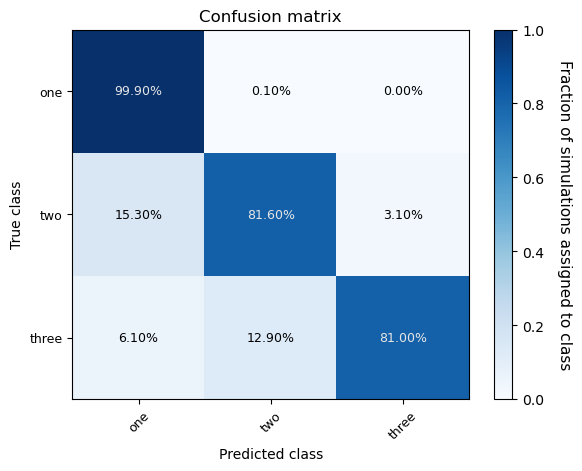

94/94 [==============================] - 0s 3ms/step
[[969  17  14]
 [133 522 345]
 [ 96 375 529]]


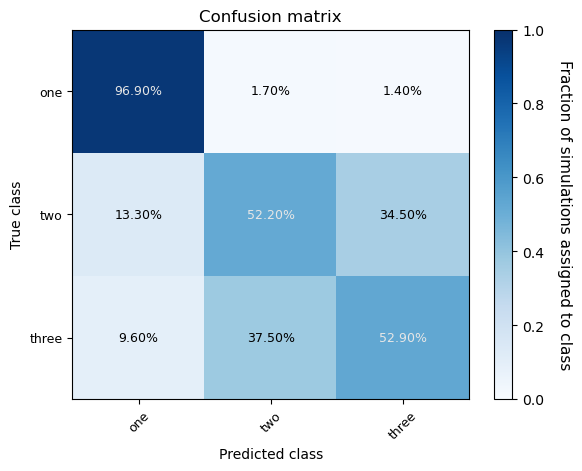

94/94 [==============================] - 0s 3ms/step


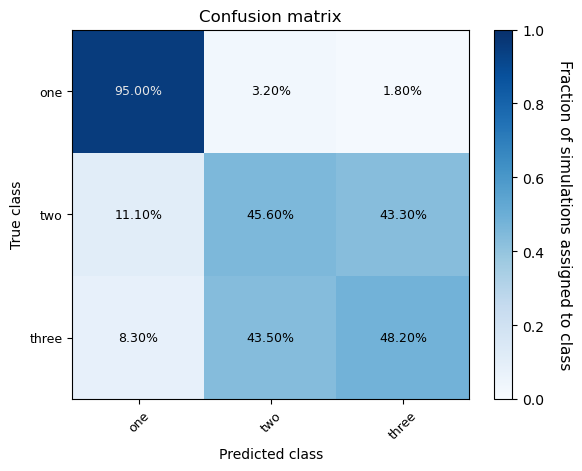

94/94 [==============================] - 0s 3ms/step
[[998   2   0]
 [185 789  26]
 [ 61 105 834]]


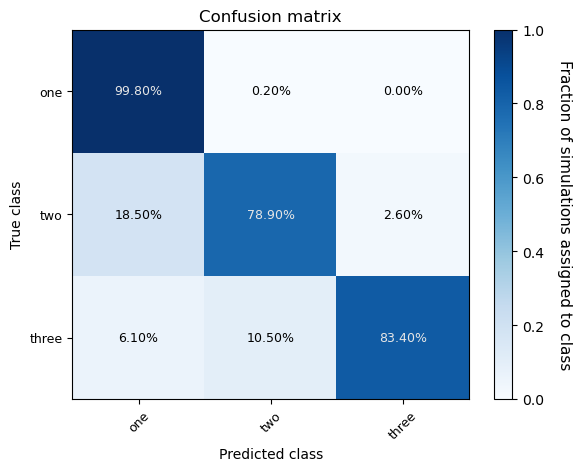

94/94 [==============================] - 0s 3ms/step
[[950  29  21]
 [111 554 335]
 [ 79 343 578]]


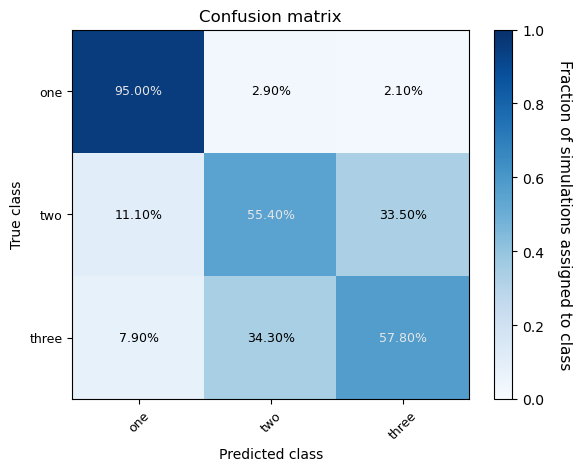

94/94 [==============================] - 0s 3ms/step


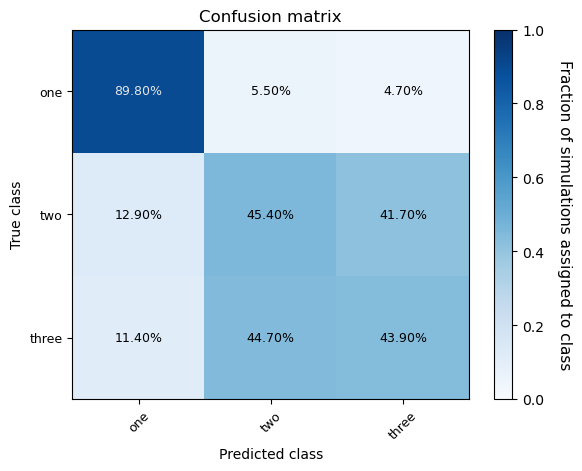

94/94 [==============================] - 0s 3ms/step


94/94 [==============================] - 0s 3ms/step


94/94 [==============================] - 0s 3ms/step


94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 4ms/step


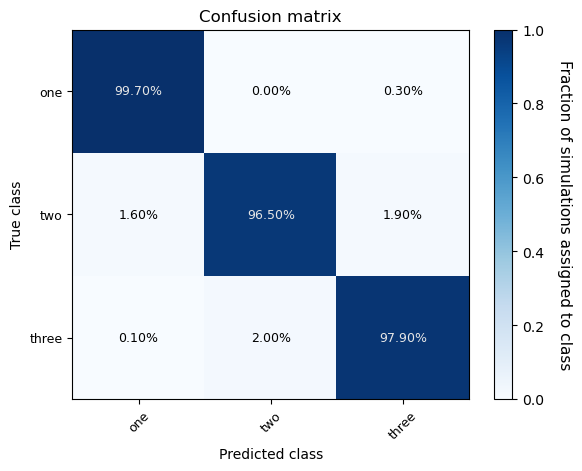

94/94 [==============================] - 1s 4ms/step


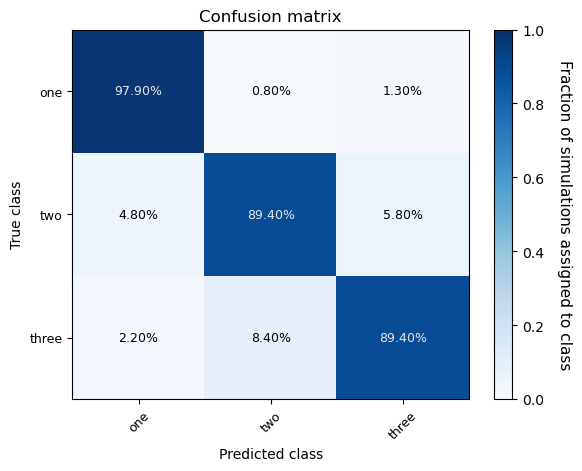

94/94 [==============================] - 1s 6ms/step


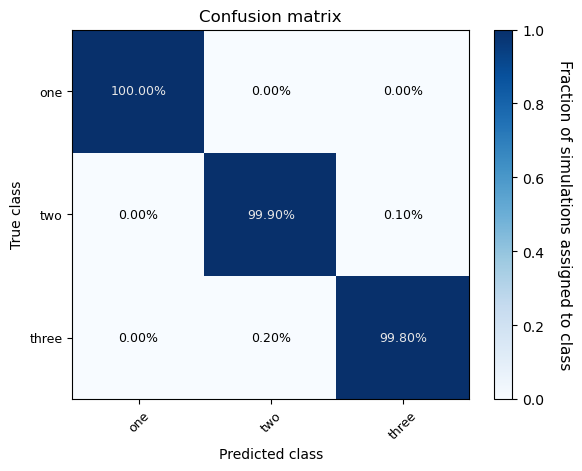

94/94 [==============================] - 1s 6ms/step


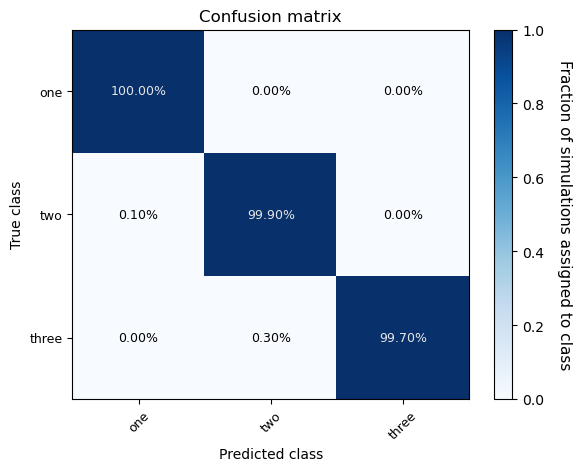

94/94 [==============================] - 1s 6ms/step


94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 5ms/step


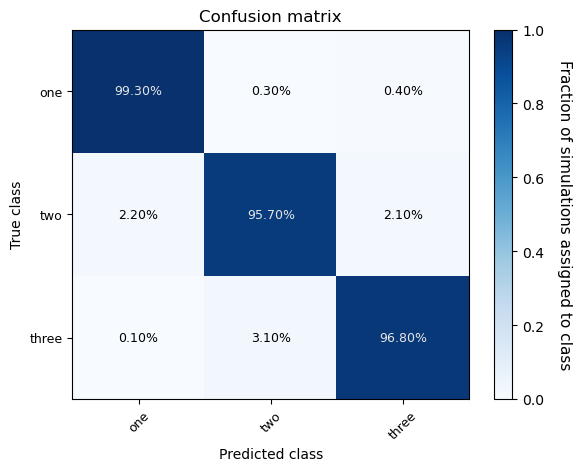

94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 5ms/step


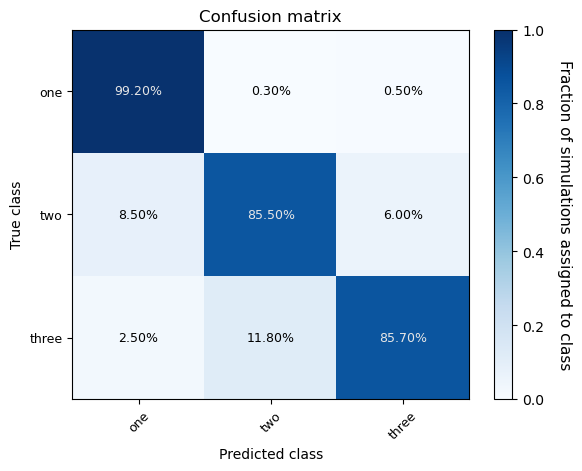

94/94 [==============================] - 1s 5ms/step


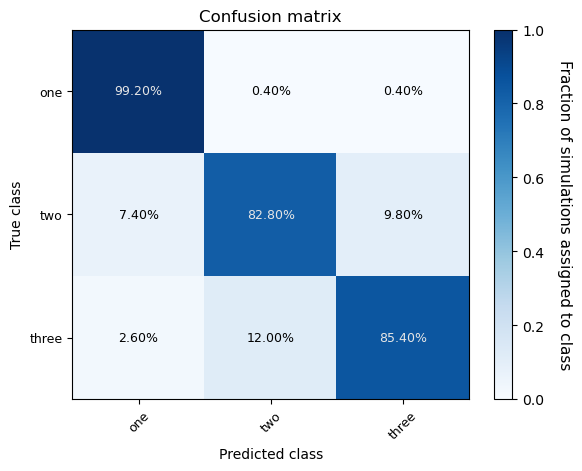

94/94 [==============================] - 1s 5ms/step


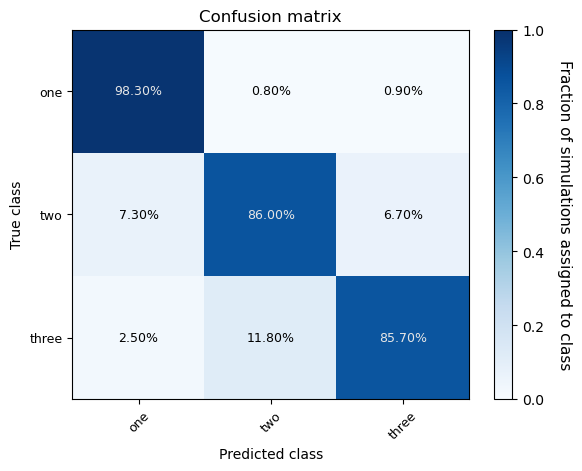

94/94 [==============================] - 1s 6ms/step


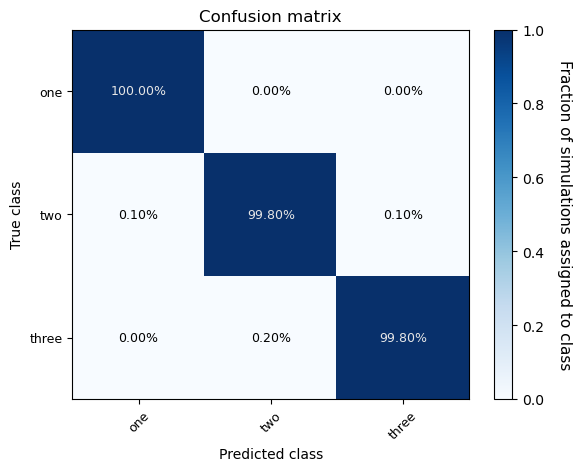

94/94 [==============================] - 1s 6ms/step


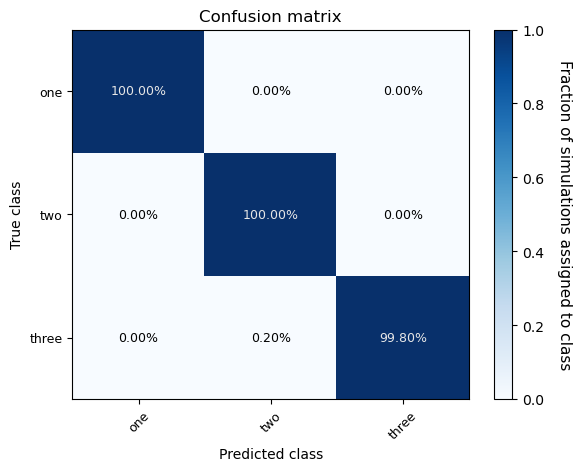

94/94 [==============================] - 1s 6ms/step


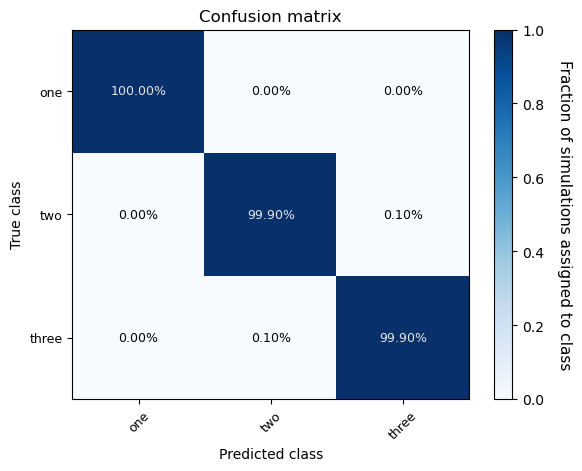

94/94 [==============================] - 1s 5ms/step


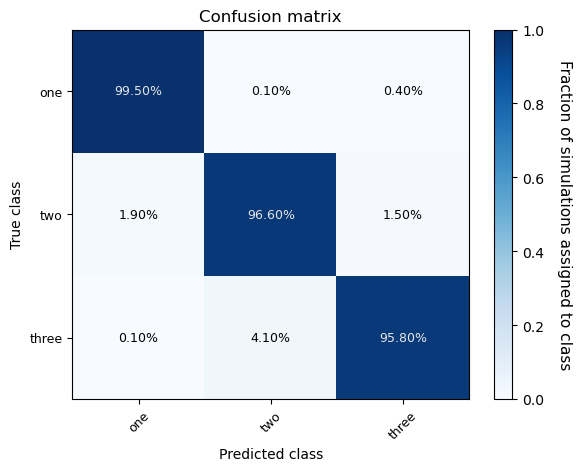

94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 5ms/step


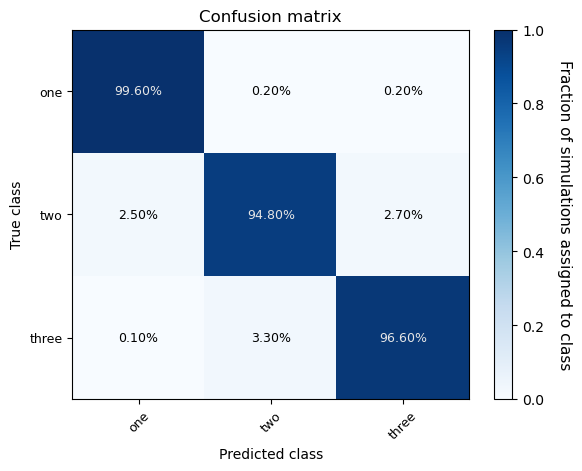

94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 5ms/step


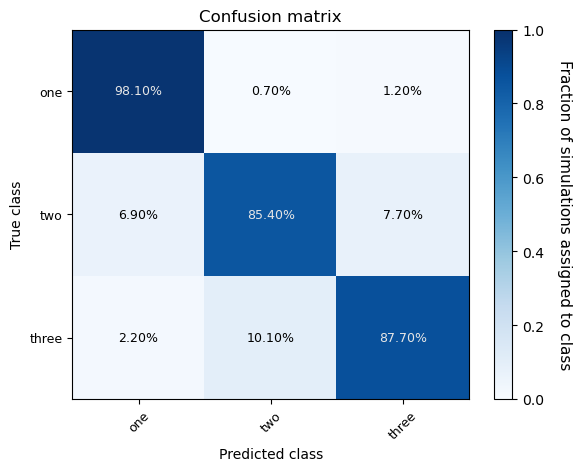

94/94 [==============================] - 1s 5ms/step


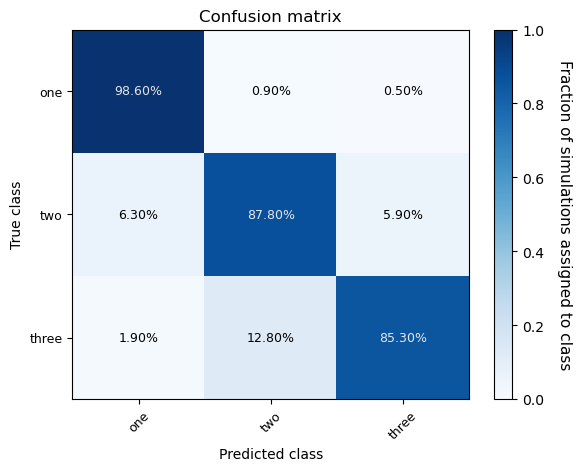

94/94 [==============================] - 1s 6ms/step


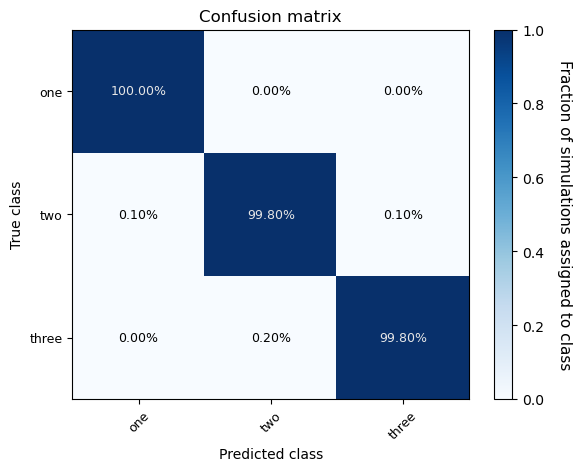

94/94 [==============================] - 1s 7ms/step


94/94 [==============================] - 1s 6ms/step


94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 5ms/step


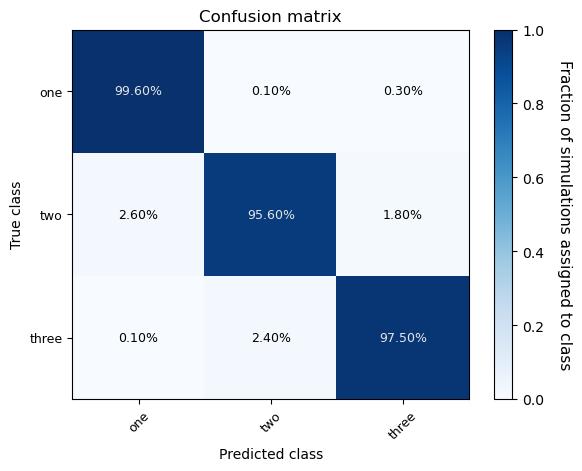

94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 5ms/step


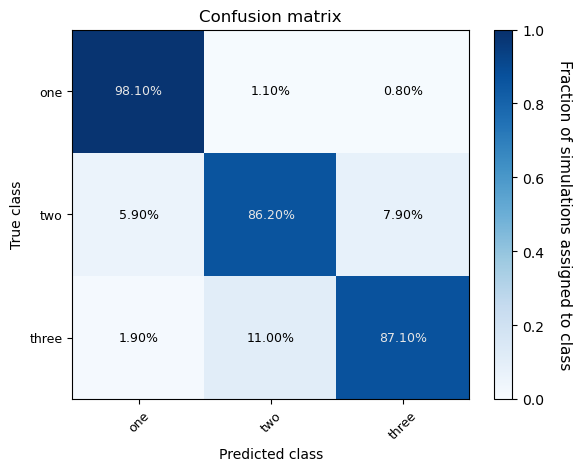

94/94 [==============================] - 1s 5ms/step


94/94 [==============================] - 1s 5ms/step


In [37]:
#now the actual work
#first get the predictions
pred = model1.predict(traits_BM.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model2.predict(traits_BM50.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#get the predictions
pred = model3.predict(traits_BM10.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model4.predict(traits_OU.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model5.predict(traits_OU50.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model6.predict(traits_OU10.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model7.predict(traits_disc.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work
#first get the predictions
pred = model8.predict(traits_disc50.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model9.predict(traits_disc10.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model10.predict(xtest)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model11.predict(xtest[:,0:50,:])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model12.predict(xtest[:,0:20,:])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model13.predict([traits_BM.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model14.predict([traits_BM50.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model15.predict([traits_BM10.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model16.predict([traits_BM.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model17.predict([traits_BM50.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model18.predict([traits_BM10.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model19.predict([traits_BM.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model20.predict([traits_BM50.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model21.predict([traits_BM10.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model22.predict([traits_OU.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model23.predict([traits_OU50.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model24.predict([traits_OU10.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model25.predict([traits_OU.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model26.predict([traits_OU50.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model27.predict([traits_OU10.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model28.predict([traits_OU.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model29.predict([traits_OU50.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model30.predict([traits_OU10.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model31.predict([traits_disc.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()


# get the predictions
pred = model32.predict([traits_disc50.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()


# get the predictions
pred = model33.predict([traits_disc10.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model34.predict([traits_disc.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model35.predict([traits_disc50.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model36.predict([traits_disc10.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model37.predict([traits_disc.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model38.predict([traits_disc50.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model39.predict([traits_disc10.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()